### Topic 1: Structural Properties of LADs
# Similarities between cells

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/1_Preimplantation.structural_properties_of_LADs.part2c.metric_of_similarity.all_Lmnb1_conditions/'

In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 1000000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = '../../combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'
ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# 1. Loading Kind data

In [5]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [6]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']
treatment_order = ['no_treatment', 'EED_ctrl', 'EED_mKO', 'Lap2b', 'Cbx7(CD)-Lap2b', 'Cbx7(CD)-Emd', 'Cbx7(CD)-Lbr']

In [7]:
anno = pd.read_csv(ANNOFN, sep='\t', dtype={'number_embryos': str})

## select samples passing quality filters
anno = anno[anno.DamID_PASS]

## select conditions of interest
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno['treatment'].isin(treatment_order)]
anno = anno[anno.cellcount == 1]

# setting stage order
anno['stage_order'] = anno['stage'].apply(func=lambda s: {stage: i for i, stage in enumerate(stage_order)}[s])
anno['stage'] = pd.Categorical(anno['stage'], categories=stage_order)
anno = anno.set_index(anno['damid_name'])

anno.head()

runid  illumina_index  damid2_adapter_number  \
damid_name                                                                      
KIN1971.index03.DamID2_BC_001  KIN1971               3                      1   
KIN1971.index03.DamID2_BC_009  KIN1971               3                      9   
KIN1971.index03.DamID2_BC_017  KIN1971               3                     17   
KIN1971.index03.DamID2_BC_025  KIN1971               3                     25   
KIN1971.index03.DamID2_BC_033  KIN1971               3                     33   

                               celseq2_adapter_number  cellcount construct  \
damid_name                                                                   
KIN1971.index03.DamID2_BC_001                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_009                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_017                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_025                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_033                       0          1     Lmnb1   

                              fusion_construct  stage     treatment  \
damid_name                                                            
KIN1971.index03.DamID2_BC_001        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_009        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_017        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_025        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_033        Dam-Lmnb1  2cell  no_treatment   

                                 genotype  ... nTranscripts  \
damid_name                                 ...                
KIN1971.index03.DamID2_BC_001  homozygous  ...            0   
KIN1971.index03.DamID2_BC_009  homozygous  ...            0   
KIN1971.index03.DamID2_BC_017  homozygous  ...            0   
KIN1971.index03.DamID2_BC_025  homozygous  ...            0   
KIN1971.index03.DamID2_BC_033  homozygous  ...            0   

                              nTranscripts_maternal nTranscripts_paternal  \
damid_name                                                                  
KIN1971.index03.DamID2_BC_001                   NaN                   NaN   
KIN1971.index03.DamID2_BC_009                   NaN                   NaN   
KIN1971.index03.DamID2_BC_017                   NaN                   NaN   
KIN1971.index03.DamID2_BC_025                   NaN                   NaN   
KIN1971.index03.DamID2_BC_033                   NaN                   NaN   

                              allelic_celseq_balance nERCC nMito DamID_PASS  \
damid_name                                                                    
KIN1971.index03.DamID2_BC_001                    NaN     0     0       True   
KIN1971.index03.DamID2_BC_009                    NaN     0     0       True   
KIN1971.index03.DamID2_BC_017                    NaN     0     0       True   
KIN1971.index03.DamID2_BC_025                    NaN     0     0       True   
KIN1971.index03.DamID2_BC_033                    NaN     0     0       True   

                               DamID_PASS_allelic CELseq_PASS stage_order  
damid_name                                                                 
KIN1971.index03.DamID2_BC_001                True       False           1  
KIN1971.index03.DamID2_BC_009                True       False           1  
KIN1971.index03.DamID2_BC_017                True       False           1  
KIN1971.index03.DamID2_BC_025                True       False           1  
KIN1971.index03.DamID2_BC_033                True       False           1  

[5 rows x 39 columns]

## 1.2 Loading mappability

In [8]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [9]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [10]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading data

__DamID sample counts__

In [11]:
damid_counts = ld.load_sample_damid_counts_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined
Dam-Lmnb1 homozygous combined


__DamID sample binary signal__

In [12]:
damid_binary = ld.load_sample_damid_binary_heterozygous(BINARY, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined
Dam-Lmnb1 homozygous combined


## 1.4 Downsampling single-cell counts

In [13]:
downsample_threshold_ls = [10000, 15000, 20000, 25000, 30000, 35000, 40000]

In [14]:
damid_counts_down = {t: dict() for t in downsample_threshold_ls}
for t in downsample_threshold_ls:
    damid_counts_down[t] = {a: dict() for a in damid_counts}
np.random.seed(1)

for downtarget in downsample_threshold_ls:
    print('downsample threshold: ', downtarget)
    for sample, row in tqdm(anno.iterrows(), total=len(anno)):
        if 'KIN' not in sample:
            print(row)

        pass_comb = row['unique_damid_counts'] >= downtarget
        pass_allelic = (row['maternal_damid_counts'] + row['paternal_damid_counts']) >= downtarget

        assert not ((not pass_comb) and (pass_allelic))

        if not pass_comb:
            continue

        allele_ls = ['combined']

        # determine number of mat and pat reads if pass allelic
        if pass_allelic:
            current = [row['maternal_damid_counts'], row['paternal_damid_counts']]
            p = downtarget/sum(current)
            new = rs.binomial(n=current, p=p)
            target = {'maternal': new[0], 'paternal': new[1]}
            allele_ls = allele_ls + ['maternal', 'paternal']

        # iterate over alleles and downsample
        for allele in allele_ls:

            t = downtarget if allele=='combined' else target[allele]
            counts = damid_counts[allele][sample]
            downcounts = downsample_counts(counts, t)
            damid_counts_down[downtarget][allele][sample] = downcounts

downsample threshold:  10000


  0%|          | 0/1140 [00:00<?, ?it/s]

downsample threshold:  15000


  0%|          | 0/1140 [00:00<?, ?it/s]

downsample threshold:  20000


  0%|          | 0/1140 [00:00<?, ?it/s]

downsample threshold:  25000


  0%|          | 0/1140 [00:00<?, ?it/s]

downsample threshold:  30000


  0%|          | 0/1140 [00:00<?, ?it/s]

downsample threshold:  35000


  0%|          | 0/1140 [00:00<?, ?it/s]

downsample threshold:  40000


  0%|          | 0/1140 [00:00<?, ?it/s]

## 1.5 Converting downsampled counts to binary contacts

In [15]:
SMOOTH_STD = 150000
W = gaussian(np.ceil(SMOOTH_STD / BINSIZE * 2 / 2) * 2 + 1, SMOOTH_STD / BINSIZE)
W /= W.sum()
W

array([2.23363144e-10, 1.00000000e+00, 2.23363144e-10])

In [16]:
damid_binary_down = {t: dict() for t in downsample_threshold_ls}
for t in downsample_threshold_ls:
    damid_binary_down[t] = {a: dict() for a in damid_counts}
    
for (genotype, is_het), anno_gt in anno.groupby(['genotype', 'is_heterozygous']):
    
    allele_ls = ['maternal', 'paternal', 'combined'] if is_het else ['combined']
        

    for allele in allele_ls:
        print(genotype, allele)

        # determine depth to normalize mappability
        if allele == 'combined':
            d = sum([mapab_gt[genotype][allele][c].sum() for c in chrom_order])
        else:
            d = 0
            for a in ['maternal','paternal']:
                d += sum([mapab_gt[genotype][a][c].sum() for c in chrom_order])

        # normalize and smooth mappability
        mapab_rpkm = rpkm_normalize(mapab_gt[genotype][allele], binsize=BINSIZE, depth=d)
        mapab_smooth = {c: fftconvolve(mapab_rpkm[c], W, mode='same') for c in chrom_order}

        for downtarget in damid_counts_down:
            
            # iterate over samples
            for sample, row in anno_gt.iterrows():
                if sample not in damid_counts_down[downtarget][allele].keys():
                    continue

                # determine depth to normalize sample
                if allele == 'combined':
                    d = sum([damid_counts_down[downtarget][allele][sample][c].sum() for c in chrom_order])
                else:
                    d = 0 
                    for a in ['maternal','paternal']:
                        d += sum([damid_counts_down[downtarget][a][sample][c].sum() for c in chrom_order])

                rpkm = rpkm_normalize(damid_counts_down[downtarget][allele][sample], binsize=BINSIZE, depth=d)
                rpkm_smooth = {c: fftconvolve(rpkm[c], W, mode='same') for c in chrom_order}
                b = {c: (rpkm_smooth[c] > mapab_smooth[c]).astype(int) for c in chrom_order}
                for c in chrom_order:
                    b[c][mapab_gt[genotype][allele][c]==0] = 0

                damid_binary_down[downtarget][allele][sample] = b

129S1/SvImJ_x_CAST/EiJ maternal
129S1/SvImJ_x_CAST/EiJ paternal
129S1/SvImJ_x_CAST/EiJ combined
C57BL/6J_x_JF1/Ms maternal
C57BL/6J_x_JF1/Ms paternal
C57BL/6J_x_JF1/Ms combined
CBAB6F1_x_CAST/EiJ maternal
CBAB6F1_x_CAST/EiJ paternal
CBAB6F1_x_CAST/EiJ combined
homozygous combined


## 1.6 Generating a simulated single-cell dataset by downsampling _in silico_ populations

In [17]:
SMOOTH_STD = 150000
W = gaussian(np.ceil(SMOOTH_STD / BINSIZE * 2 / 2) * 2 + 1, SMOOTH_STD / BINSIZE)
W /= W.sum()
W

array([2.23363144e-10, 1.00000000e+00, 2.23363144e-10])

In [18]:
select_chroms = chrom_order
damid_counts_sim = {p: dict() for p in ['combined', 'maternal', 'paternal']}
damid_binary_sim = {p: dict() for p in ['combined', 'maternal', 'paternal']}
damid_counts_down_sim = dict()
damid_binary_down_sim = dict()
for downtarget in damid_counts_down:
    damid_counts_down_sim[downtarget] = {p: dict() for p in ['combined', 'maternal', 'paternal']}
    damid_binary_down_sim[downtarget] = {p: dict() for p in ['combined', 'maternal', 'paternal']}

# compute RPKM normalized mappability
mapab_smooth = dict()
for gt in mapab_gt:
    if 'maternal' in mapab_gt[gt]:
        d_allelic = sum([mapab_gt[gt]['maternal'][c].sum() + mapab_gt[gt]['paternal'][c].sum() for c in select_chroms])
    d_comb = sum([mapab_gt[gt]['combined'][c].sum() for c in select_chroms])
    mapab_smooth[gt] = dict()
    
    for parent in mapab_gt[gt]:
        if parent == 'combined':
            rpkm = rpkm_normalize({c: mapab_gt[gt][parent][c] for c in select_chroms}, binsize=BINSIZE, depth=d_comb)
        else:
            rpkm = rpkm_normalize({c: mapab_gt[gt][parent][c] for c in select_chroms}, binsize=BINSIZE, depth=d_allelic)
        mapab_smooth[gt][parent] = {c: fftconvolve(rpkm[c], W, mode='same') for c in select_chroms}
    
seed = 0

# iterate over samples and generate single-cell binary
for (stage, genotype, treatment, runid, is_het), df in anno.groupby(['stage', 'genotype', 'treatment', 'runid', 'is_heterozygous']):
    
    if len(df) == 0:
        continue
        
    parent_pops = dict()
    
    allele_ls = ['combined', 'maternal', 'paternal'] if is_het else ['combined']
        
    # generate downsampled counts
    for parent in allele_ls:
        
        samples = df.index.values if parent == 'combined' else df[df.DamID_PASS_allelic].index.values

        # generate in silico combined counts for this run
        pop = {c: np.zeros(len(mapab[c])) for c in select_chroms}
        for sample in samples:
            pop = {c: pop[c] + damid_counts[parent][sample][c] for c in select_chroms}
        Tpop = int(sum([pop[c].sum() for c in select_chroms]))
        

        # iterate over single-cell samples and generate downsampled equivalents
        print(stage, genotype, treatment, runid, parent, Tpop, len(samples))
        for sample in samples:

            # determine depth of this sample
            t = sum([damid_counts[parent][sample][c].sum() for c in select_chroms])

            # create downsampled simulated single-cell sample from population
            counts = downsample_counts(pop, downtarget=t, seed=seed)
            seed += 1
            damid_counts_sim[parent][sample] = counts
            
            # do the same for the downsampled cases
            for downtarget in damid_counts_down:
                if sample in damid_counts_down[downtarget][parent]:
                    t = sum([damid_counts_down[downtarget][parent][sample][c].sum() for c in select_chroms])

                    # create downsampled simulated single-cell sample from population
                    counts = downsample_counts(pop, downtarget=t, seed=seed)
                    damid_counts_down_sim[downtarget][parent][sample] = counts
            
    # depth-normalize and binarize counts
    for parent in allele_ls:
        
        # depth normalize and binarize simulated data
        samples = df.index.values if parent == 'combined' else df[df.DamID_PASS_allelic].index.values
        
        for sample in samples:
            counts = damid_counts_sim[parent][sample]
            if parent == 'combined':
                d = sum([counts[c].sum() for c in select_chroms])
            else:
                d = sum([damid_counts_sim['maternal'][sample][c].sum() + damid_counts_sim['paternal'][sample][c].sum() for c in select_chroms])

            # binarization based on mappability-normalized data
            rpkm = rpkm_normalize(counts, binsize=BINSIZE, depth=d)
            rpkm_smooth = {c: fftconvolve(rpkm[c], W, mode='same') for c in select_chroms}

            b = dict()
            for c in select_chroms:
                b[c] = (rpkm_smooth[c] > mapab_smooth[genotype][parent][c]).astype(int)
                b[c][mapab_gt[genotype][parent][c]==0] = 0

            damid_binary_sim[parent][sample] = b
            
        # depth normalize and binarize simulated downsampled data
        for downtarget in damid_counts_down_sim:
            samples = damid_counts_down_sim[downtarget][parent].keys()

            for sample in samples:
                counts = damid_counts_down_sim[downtarget][parent][sample]
                if parent == 'combined':
                    d = sum([counts[c].sum() for c in select_chroms])
                else:
                    d = sum([damid_counts_down_sim[downtarget]['maternal'][sample][c].sum() + damid_counts_down_sim[downtarget]['paternal'][sample][c].sum() for c in select_chroms])

                # binarization based on mappability-normalized data
                rpkm = rpkm_normalize(counts, binsize=BINSIZE, depth=d)
                rpkm_smooth = {c: fftconvolve(rpkm[c], W, mode='same') for c in select_chroms}

                b = dict()
                for c in select_chroms:
                    b[c] = (rpkm_smooth[c] > mapab_smooth[genotype][parent][c]).astype(int)
                    b[c][mapab_gt[genotype][parent][c]==0] = 0

                damid_binary_down_sim[downtarget][parent][sample] = b

zygote CBAB6F1_x_CAST/EiJ no_treatment KIN6777 combined 121389 12
zygote CBAB6F1_x_CAST/EiJ no_treatment KIN6777 maternal 24074 11
zygote CBAB6F1_x_CAST/EiJ no_treatment KIN6777 paternal 40584 11
zygote CBAB6F1_x_CAST/EiJ no_treatment KIN7553 combined 15819 2
zygote CBAB6F1_x_CAST/EiJ no_treatment KIN7553 maternal 4017 2
zygote CBAB6F1_x_CAST/EiJ no_treatment KIN7553 paternal 5684 2
zygote homozygous no_treatment KIN2577 combined 52017 8
zygote homozygous no_treatment KIN3934 combined 878018 48
zygote homozygous no_treatment KIN4612 combined 920835 27
zygote homozygous no_treatment KIN4951 combined 800736 24
2cell C57BL/6J_x_JF1/Ms EED_ctrl KIN6777 combined 441769 30
2cell C57BL/6J_x_JF1/Ms EED_ctrl KIN6777 maternal 12562 2
2cell C57BL/6J_x_JF1/Ms EED_ctrl KIN6777 paternal 12247 2
2cell C57BL/6J_x_JF1/Ms EED_ctrl KIN7437 combined 2966621 57
2cell C57BL/6J_x_JF1/Ms EED_ctrl KIN7437 maternal 619762 49
2cell C57BL/6J_x_JF1/Ms EED_ctrl KIN7437 paternal 552745 49
2cell C57BL/6J_x_JF1/Ms EED

## 1.7 Loading allele visibility

In [19]:
allele_filt_gt = dict()

for gt in GENOTYPE2PARENT:
    
    fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=BINSIZE)
    allele_filt_gt[gt] = dict()
    
    with h5py.File(fn, 'r') as f:
        for c in chrom_order:
            allele_filt_gt[gt][c] = f[c][:].astype(bool)
    
allele_filt_total = dict()

for c in chrom_order:
    filt = np.array([allele_filt_gt[gt][c] for gt in allele_filt_gt]).astype(int)
    filt = filt.sum(axis=0) == len(allele_filt_gt.keys())
    allele_filt_total[c] = filt

# 2. Compute cell-to-cell similarities

Only take somatic chromosomes into account

In [20]:
from collections import defaultdict

In [21]:
from sklearn.metrics import pairwise_distances

## 2.1 Compute similarities

In [22]:
import sklearn

In [23]:
# RPKM normalize mappability data
mapab_rpkm = dict()
for gt in mapab_gt:
    mapab_rpkm[gt] = dict()
    
    for p in mapab_gt[gt]:
        m = mapab_gt[gt][p]
        
        if p in ['maternal', 'paternal']:
            dm = sum([mapab_gt[gt]['maternal'][c].sum() for c in chrom_order])
            dp = sum([mapab_gt[gt]['paternal'][c].sum() for c in chrom_order])
            d = dm+dp
            m = rpkm_normalize(m, binsize=BINSIZE, depth=d)
        else:
            m = rpkm_normalize(m, binsize=BINSIZE)
            
        mapab_rpkm[gt][p] = m

In [24]:
select_chroms = np.arange(1,20).astype(str)
pairwise_similarity_scores = dict()
m_ind = np.concatenate([mapab[c] for c in select_chroms]) > MINMAP


dataset_dict = {
    'full_orig': damid_binary,
    'full_sim': damid_binary_sim
}
dataset_counts_dict = {
    'full_orig': damid_counts,
    'full_sim': damid_counts_sim
}

for downtarget in damid_binary_down:
    dataset_dict['down_%d_orig' % downtarget] = damid_binary_down[downtarget]
    dataset_dict['down_%d_sim' % downtarget] = damid_binary_down_sim[downtarget]
    dataset_counts_dict['down_%d_orig' % downtarget] = damid_counts_down[downtarget]
    dataset_counts_dict['down_%d_sim' % downtarget] = damid_counts_down_sim[downtarget]

for info, anno_df in anno[anno.cellcount == 1].groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']):
    allele_ls = ['maternal', 'paternal', 'combined'] if info[-1] else ['combined']
    info = (info[0], info[1], info[2])
    
    
    result_ls = list()
    
    for parent in allele_ls:
        samples = anno_df.index.values if parent == 'combined' else anno_df[anno_df.DamID_PASS_allelic].index.values

        if parent == 'combined':
            filt = m_ind
        else:
            a_ind = np.concatenate([allele_filt_gt[info[1]][c] for c in select_chroms])
            filt = m_ind & a_ind
             
        for ds in dataset_dict:
            
            tmp = np.array(list(dataset_dict[ds][parent].keys()))
            select_ind = np.isin(samples, tmp)
            select_samples = samples[select_ind]
            
            ## select binary data
            D = list()
            for s in select_samples: # somatic chromosomes only
                y = np.concatenate([dataset_dict[ds][parent][s][c] for c in select_chroms])[filt]
                D.append(y)
            D = np.array(D)
            
            if D.shape[0] < 2:
                continue

            print(info, parent, ds, len(select_samples))
            
            ## jaccard on binary data
            C = 1 - pairwise_distances(D.astype(bool), metric='jaccard')
            df = pd.DataFrame(C, columns=select_samples, index=select_samples).reset_index().rename(columns={'index': 'sample1'})
            df = df.melt(id_vars='sample1', var_name='sample2', value_name='similarity')
            df['metric'] = 'Jaccard'
            df['dataset'] = ds
            df['allele'] = parent
            result_ls.append(df)

            ## yule on binary data
            C = 1 - pairwise_distances(D.astype(bool), metric='yule')
            df = pd.DataFrame(C, columns=select_samples, index=select_samples).reset_index().rename(columns={'index': 'sample1'})
            df = df.melt(id_vars='sample1', var_name='sample2', value_name='similarity')
            df['metric'] = 'Yule'
            df['dataset'] = ds
            df['allele'] = parent
            result_ls.append(df)
            
            ## select lognorm data
            D = list()
            for s in select_samples:
                m = np.concatenate([mapab_rpkm[info[1]][parent][c] for c in select_chroms])[filt]
                
                if parent == 'combined':
                    y = np.concatenate([dataset_counts_dict[ds][parent][s][c] for c in select_chroms])[filt]
                    d = sum(y)
                else:
                    ym = np.concatenate([dataset_counts_dict[ds]['maternal'][s][c] for c in select_chroms])[filt]
                    dm = sum(ym)
                    yp = np.concatenate([dataset_counts_dict[ds]['paternal'][s][c] for c in select_chroms])[filt]
                    dp = sum(yp)
                    y = ym if parent == 'maternal' else yp
                    d = dm + dp
                y = y / d / BINSIZE * 1e9
                D.append(np.log2( (y + 1) / (m + 1) ))
                
            ## Spearman on logOE
            D = np.array(D).T
            D = pd.DataFrame(D, columns=select_samples)
            C = D.corr(method='spearman')
#             C = 1 - pairwise_distances(D.astype(bool), metric='yule')
            df = pd.DataFrame(C, columns=select_samples, index=select_samples).reset_index().rename(columns={'index': 'sample1'})
            df = df.melt(id_vars='sample1', var_name='sample2', value_name='similarity')
            df['metric'] = 'Spearman'
            df['dataset'] = ds
            df['allele'] = parent
            result_ls.append(df)
            
    if len(result_ls) == 1:
        result_df = result_ls[0]
    elif len(result_ls) == 0:
        continue
    else:
        result_df = pd.concat(result_ls, axis=0)
    pairwise_similarity_scores[info] = result_df

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal full_orig 13
('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal full_sim 13
('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal full_orig 13
('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal full_sim 13
('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined full_orig 14
('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined full_sim 14
('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined down_10000_orig 3
('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined down_10000_sim 3
('zygote', 'homozygous', 'no_treatment') combined full_orig 107
('zygote', 'homozygous', 'no_treatment') combined full_sim 107
('zygote', 'homozygous', 'no_treatment') combined down_10000_orig 84
('zygote', 'homozygous', 'no_treatment') combined down_10000_sim 84
('zygote', 'homozygous', 'no_treatment') combined down_15000_orig 62
('zygote', 'homozygous', 'no_treatment') combined down_15000_sim 62
('zygote', 'homozygous', 

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal full_sim 39
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_10000_orig 39
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_10000_sim 39
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_15000_orig 39
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_15000_sim 39
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_20000_orig 35
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_20000_sim 35
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_25000_orig 32
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_25000_sim 32
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_30000_orig 26
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_30000_sim 26
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_35000_orig 24
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal down_35000_sim 24

('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal down_20000_sim 14
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal down_25000_orig 13
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal down_25000_sim 13
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal down_30000_orig 13
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal down_30000_sim 13
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal down_35000_orig 13
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal down_35000_sim 13
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal down_40000_orig 12
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal down_40000_sim 12
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined full_orig 26
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined full_sim 26
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined down_10000_orig 26
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined down_10000_sim 26
('2cell', 'CBAB6F1_x_CAST/EiJ',

('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined down_20000_sim 16
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined down_25000_orig 8
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined down_25000_sim 8
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined down_30000_orig 7
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined down_30000_sim 7
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined down_35000_orig 5
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined down_35000_sim 5
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal full_orig 17
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal full_sim 17
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal down_10000_orig 17
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal down_10000_sim 17
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal down_15000_orig 12
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal down_15000_sim 12
('8cell', 'CBAB6F1_x_CA

('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined down_20000_sim 209
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined down_25000_orig 178
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined down_25000_sim 178
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined down_30000_orig 159
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined down_30000_sim 159
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined down_35000_orig 130
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined down_35000_sim 130
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined down_40000_orig 104
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined down_40000_sim 104


## 2.2 Inspect relationship between depth and similarity scores

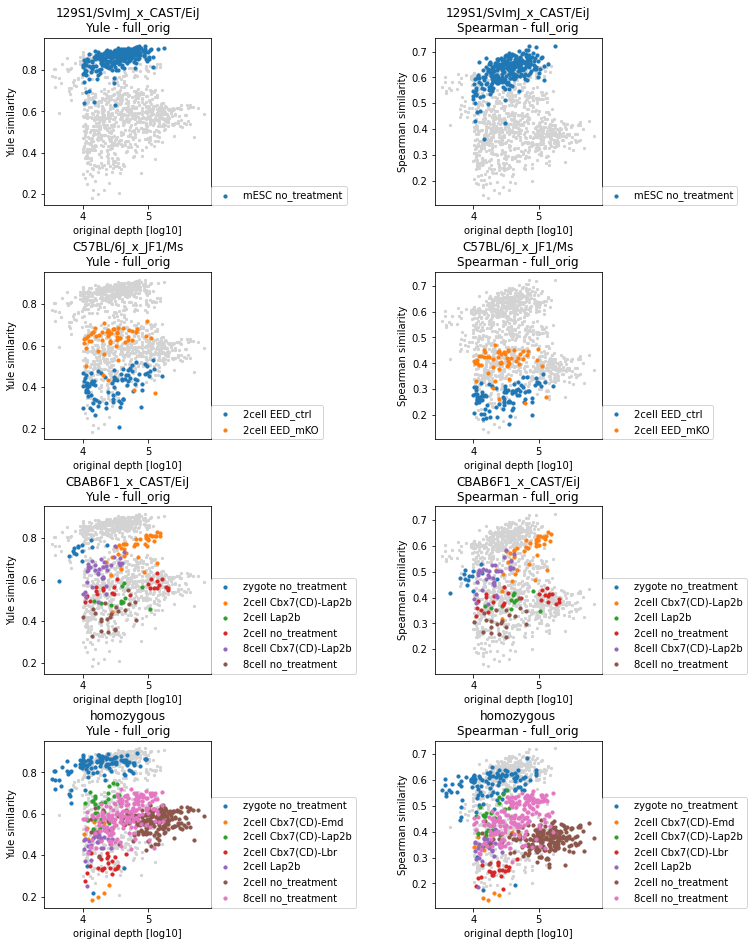

In [25]:
g_anno = anno.groupby('genotype')
metrics_to_plot = [
    ('Yule', 'full_orig'), ('Spearman', 'full_orig') 
#     ('Jaccard', 'full_orig'), ('Jaccard', 'down_orig')
]

nrow = len(list(g_anno))
ncol = len(metrics_to_plot)

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*6, nrow*4))
plt.subplots_adjust(hspace=.4, wspace=.4)
irow = -1

## collect plottables
plot_dict = dict()
for info in pairwise_similarity_scores:
    plot_dict[info] = dict()
    
    for comb in metrics_to_plot:
        
        to_plot = pairwise_similarity_scores[info].copy()
        to_plot = to_plot[(to_plot['metric'] == comb[0]) & (to_plot['dataset'] == comb[1])]
        to_plot = to_plot[to_plot['allele'] == 'combined']
        
        to_plot = to_plot[to_plot['sample1'] != to_plot['sample2']]
        
        if len(to_plot) == 0:
            continue
        
        to_plot = to_plot.groupby(['sample1']).agg({'similarity': np.median}).reset_index()
        to_plot['depth'] = anno.loc[to_plot['sample1'].values, 'unique_damid_counts'].values
        plot_dict[info][comb] = to_plot
        

for genotype, _ in g_anno:
    irow += 1
    
    for icol, comb in enumerate(metrics_to_plot):
        
        ax = axes[irow,icol]
        ax.set_title('%s\n%s - %s' % (genotype, comb[0], comb[1]))
        ax.set_xlabel('original depth [log10]')
        ax.set_ylabel('%s similarity' % comb[0])
        ax.set_box_aspect(1)
        
        # plot other genotypes
        for info in plot_dict:
            if info[1] == genotype:
                continue
            if comb not in plot_dict[info]:
                continue
            tmp = plot_dict[info][comb].copy()
            X = np.log10(tmp['depth'])
            Y = tmp['similarity']
            ax.scatter(X, Y, color='lightgrey', s=5)
            
        # plot current condition
        for info in plot_dict:
            if info[1] != genotype:
                continue
            if comb not in plot_dict[info]:
                continue
            tmp = plot_dict[info][comb].copy()
            X = np.log10(tmp['depth'])
            Y = tmp['similarity']
            ax.scatter(X, Y, s=10, label='%s %s' % (info[0], info[2]))
            
            

        ax.legend(loc=(1,0))
    

## 2.3 Compute cell-to-cell similarity - per chromosome

In [26]:
chrom_orderder

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 'X',
 'Y']

In [27]:
anno_df

runid  illumina_index  damid2_adapter_number  \
damid_name                                                                      
KIN6284.index01.DamID2_BC_001  KIN6284               1                      1   
KIN6284.index01.DamID2_BC_002  KIN6284               1                      2   
KIN6284.index01.DamID2_BC_003  KIN6284               1                      3   
KIN6284.index01.DamID2_BC_004  KIN6284               1                      4   
KIN6284.index01.DamID2_BC_005  KIN6284               1                      5   
...                                ...             ...                    ...   
KIN6284.index01.DamID2_BC_380  KIN6284               1                    380   
KIN6284.index01.DamID2_BC_381  KIN6284               1                    381   
KIN6284.index01.DamID2_BC_382  KIN6284               1                    382   
KIN6284.index01.DamID2_BC_383  KIN6284               1                    383   
KIN6284.index01.DamID2_BC_384  KIN6284               1                    384   

                               celseq2_adapter_number  cellcount construct  \
damid_name                                                                   
KIN6284.index01.DamID2_BC_001                       1          1     Lmnb1   
KIN6284.index01.DamID2_BC_002                       2          1     Lmnb1   
KIN6284.index01.DamID2_BC_003                       3          1     Lmnb1   
KIN6284.index01.DamID2_BC_004                       4          1     Lmnb1   
KIN6284.index01.DamID2_BC_005                       5          1     Lmnb1   
...                                               ...        ...       ...   
KIN6284.index01.DamID2_BC_380                     380          1     Lmnb1   
KIN6284.index01.DamID2_BC_381                     381          1     Lmnb1   
KIN6284.index01.DamID2_BC_382                     382          1     Lmnb1   
KIN6284.index01.DamID2_BC_383                     383          1     Lmnb1   
KIN6284.index01.DamID2_BC_384                     384          1     Lmnb1   

                              fusion_construct stage     treatment  \
damid_name                                                           
KIN6284.index01.DamID2_BC_001        Dam-Lmnb1  mESC  no_treatment   
KIN6284.index01.DamID2_BC_002        Dam-Lmnb1  mESC  no_treatment   
KIN6284.index01.DamID2_BC_003        Dam-Lmnb1  mESC  no_treatment   
KIN6284.index01.DamID2_BC_004        Dam-Lmnb1  mESC  no_treatment   
KIN6284.index01.DamID2_BC_005        Dam-Lmnb1  mESC  no_treatment   
...                                        ...   ...           ...   
KIN6284.index01.DamID2_BC_380        Dam-Lmnb1  mESC  no_treatment   
KIN6284.index01.DamID2_BC_381        Dam-Lmnb1  mESC  no_treatment   
KIN6284.index01.DamID2_BC_382        Dam-Lmnb1  mESC  no_treatment   
KIN6284.index01.DamID2_BC_383        Dam-Lmnb1  mESC  no_treatment   
KIN6284.index01.DamID2_BC_384        Dam-Lmnb1  mESC  no_treatment   

                                             genotype  ... nTranscripts  \
damid_name                                             ...                
KIN6284.index01.DamID2_BC_001  129S1/SvImJ_x_CAST/EiJ  ...        32445   
KIN6284.index01.DamID2_BC_002  129S1/SvImJ_x_CAST/EiJ  ...         1912   
KIN6284.index01.DamID2_BC_003  129S1/SvImJ_x_CAST/EiJ  ...        26216   
KIN6284.index01.DamID2_BC_004  129S1/SvImJ_x_CAST/EiJ  ...        16230   
KIN6284.index01.DamID2_BC_005  129S1/SvImJ_x_CAST/EiJ  ...         7235   
...                                               ...  ...          ...   
KIN6284.index01.DamID2_BC_380  129S1/SvImJ_x_CAST/EiJ  ...        32235   
KIN6284.index01.DamID2_BC_381  129S1/SvImJ_x_CAST/EiJ  ...        62323   
KIN6284.index01.DamID2_BC_382  129S1/SvImJ_x_CAST/EiJ  ...        14879   
KIN6284.index01.DamID2_BC_383  129S1/SvImJ_x_CAST/EiJ  ...        22137   
KIN6284.index01.DamID2_BC_384  129S1/SvImJ_x_CAST/EiJ  ...        13991   

                              nTranscripts_maternal nTranscripts_paternal  \


In [49]:
del chrom_pairwise_similarity_scores

In [56]:
select_chroms = chrom_order[:-1]
chrom_pairwise_similarity_scores = dict()
m_ind = np.concatenate([mapab[c] for c in chrom_order]) > MINMAP

dataset_dict = {
    'full_orig': damid_binary,
    'full_sim': damid_binary_sim
}
dataset_counts_dict = {
    'full_orig': damid_counts,
    'full_sim': damid_counts_sim
}

for downtarget in damid_binary_down:
    dataset_dict['down_%d_orig' % downtarget] = damid_binary_down[downtarget]
    dataset_dict['down_%d_sim' % downtarget] = damid_binary_down_sim[downtarget]
    dataset_counts_dict['down_%d_orig' % downtarget] = damid_counts_down[downtarget]
    dataset_counts_dict['down_%d_sim' % downtarget] = damid_counts_down_sim[downtarget]

for info, anno_df in anno[anno.cellcount == 1].groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']):
    allele_ls = ['maternal', 'paternal', 'combined'] if info[-1] else ['combined']
    info = (info[0], info[1], info[2])
    
    result_ls = list()
    sex_ind_dict = {'all': anno_df.index==anno_df.index, 'female': anno_df.sex=='female', 'male': anno_df.sex=='male'}
    
    for sex, sex_ind in sex_ind_dict.items():
    
        for parent in allele_ls:
            samples = anno_df[sex_ind].index.values if parent == 'combined' else anno_df[anno_df.DamID_PASS_allelic&sex_ind].index.values
            if len(samples) < 2:
                continue
                
            print(info, sex, parent, ds, len(samples))
                
            for chrom in tqdm(select_chroms):
                
                if (sex != 'all') and (chrom != 'X'):
                    continue

                if parent == 'combined':
                    filt = (mapab[chrom] > MINMAP)
                    filt_all = m_ind
                else:
                    filt = (mapab[chrom] > MINMAP) & allele_filt_gt[info[1]][chrom]
                    filt_all = m_ind & np.concatenate([allele_filt_gt[info[1]][c] for c in chrom_order])

                for ds in dataset_dict:

                    tmp = np.array(list(dataset_dict[ds][parent].keys()))
                    select_ind = np.isin(samples, tmp)
                    select_samples = samples[select_ind]

                    ## select binary data
                    D = np.array([dataset_dict[ds][parent][s][chrom] for s in select_samples])
                    if D.shape[0] < 2:
                        continue

                    ## yule on binary data
                    C = 1 - pairwise_distances(D.astype(bool), metric='yule')
                    df = pd.DataFrame(C, columns=select_samples, index=select_samples).reset_index().rename(columns={'index': 'sample1'})
                    df = df.melt(id_vars='sample1', var_name='sample2', value_name='similarity')
                    df['metric'] = 'Yule'
                    df['dataset'] = ds
                    df['allele'] = parent
                    df['sex'] = sex
                    df['chrom'] = chrom
                    result_ls.append(df)

            
    if len(result_ls) == 1:
        result_df = result_ls[0]
    elif len(result_ls) == 0:
        continue
    else:
        result_df = pd.concat(result_ls, axis=0).reset_index(drop=True)
    print(len(result_df))
    chrom_pairwise_similarity_scores[info] = result_df

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') all maternal down_40000_sim 13


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') all paternal down_40000_sim 13


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') all combined down_40000_sim 14


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') female maternal down_40000_sim 5


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') female paternal down_40000_sim 5


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') female combined down_40000_sim 5


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') male maternal down_40000_sim 8


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') male paternal down_40000_sim 8


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') male combined down_40000_sim 9


  0%|          | 0/20 [00:00<?, ?it/s]

22306
('zygote', 'homozygous', 'no_treatment') all combined down_40000_sim 107


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'homozygous', 'no_treatment') female combined down_40000_sim 38


  0%|          | 0/20 [00:00<?, ?it/s]

('zygote', 'homozygous', 'no_treatment') male combined down_40000_sim 69


  0%|          | 0/20 [00:00<?, ?it/s]

1161062
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') all maternal down_40000_sim 51


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') all paternal down_40000_sim 51


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') all combined down_40000_sim 87


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') female maternal down_40000_sim 23


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') female paternal down_40000_sim 23


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') female combined down_40000_sim 38


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') male maternal down_40000_sim 28


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') male paternal down_40000_sim 28


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') male combined down_40000_sim 49


  0%|          | 0/20 [00:00<?, ?it/s]

1803012
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') all maternal down_40000_sim 31


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') all paternal down_40000_sim 31


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') all combined down_40000_sim 54


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') female maternal down_40000_sim 12


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') female paternal down_40000_sim 12


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') female combined down_40000_sim 25


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') male maternal down_40000_sim 19


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') male paternal down_40000_sim 19


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') male combined down_40000_sim 29


  0%|          | 0/20 [00:00<?, ?it/s]

644252
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') all maternal down_40000_sim 39


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') all paternal down_40000_sim 39


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') all combined down_40000_sim 39


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') female maternal down_40000_sim 19


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') female paternal down_40000_sim 19


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') female combined down_40000_sim 19


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') male maternal down_40000_sim 20


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') male paternal down_40000_sim 20


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') male combined down_40000_sim 20


  0%|          | 0/20 [00:00<?, ?it/s]

1145164
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b') all maternal down_40000_sim 10


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b') all paternal down_40000_sim 10


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b') all combined down_40000_sim 11


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b') female maternal down_40000_sim 7


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b') female paternal down_40000_sim 7


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b') female combined down_40000_sim 7


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b') male maternal down_40000_sim 3


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b') male paternal down_40000_sim 3


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b') male combined down_40000_sim 4


  0%|          | 0/20 [00:00<?, ?it/s]

62200
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') all maternal down_40000_sim 21


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') all paternal down_40000_sim 21


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') all combined down_40000_sim 26


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') female maternal down_40000_sim 17


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') female paternal down_40000_sim 17


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') female combined down_40000_sim 20


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') male maternal down_40000_sim 4


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') male paternal down_40000_sim 4


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') male combined down_40000_sim 6


  0%|          | 0/20 [00:00<?, ?it/s]

292938
('2cell', 'homozygous', 'Cbx7(CD)-Emd') all combined down_40000_sim 17


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'Cbx7(CD)-Emd') female combined down_40000_sim 7


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'Cbx7(CD)-Emd') male combined down_40000_sim 10


  0%|          | 0/20 [00:00<?, ?it/s]

32676
('2cell', 'homozygous', 'Cbx7(CD)-Lap2b') all combined down_40000_sim 28


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'Cbx7(CD)-Lap2b') female combined down_40000_sim 11


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'Cbx7(CD)-Lap2b') male combined down_40000_sim 17


  0%|          | 0/20 [00:00<?, ?it/s]

89732
('2cell', 'homozygous', 'Cbx7(CD)-Lbr') all combined down_40000_sim 22


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'Cbx7(CD)-Lbr') female combined down_40000_sim 7


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'Cbx7(CD)-Lbr') male combined down_40000_sim 15


  0%|          | 0/20 [00:00<?, ?it/s]

63932
('2cell', 'homozygous', 'Lap2b') all combined down_40000_sim 31


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'Lap2b') female combined down_40000_sim 22


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'Lap2b') male combined down_40000_sim 9


  0%|          | 0/20 [00:00<?, ?it/s]

98726
('2cell', 'homozygous', 'no_treatment') all combined down_40000_sim 197


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'no_treatment') female combined down_40000_sim 88


  0%|          | 0/20 [00:00<?, ?it/s]

('2cell', 'homozygous', 'no_treatment') male combined down_40000_sim 109


  0%|          | 0/20 [00:00<?, ?it/s]

11991630
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') all maternal down_40000_sim 22


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') all paternal down_40000_sim 22


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') all combined down_40000_sim 35


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') female maternal down_40000_sim 12


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') female paternal down_40000_sim 12


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') female combined down_40000_sim 17


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') male maternal down_40000_sim 10


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') male paternal down_40000_sim 10


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') male combined down_40000_sim 18


  0%|          | 0/20 [00:00<?, ?it/s]

229648
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') all maternal down_40000_sim 17


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') all paternal down_40000_sim 17


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') all combined down_40000_sim 21


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') female maternal down_40000_sim 11


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') female paternal down_40000_sim 11


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') female combined down_40000_sim 14


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') male maternal down_40000_sim 6


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') male paternal down_40000_sim 6


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') male combined down_40000_sim 7


  0%|          | 0/20 [00:00<?, ?it/s]

137964
('8cell', 'homozygous', 'no_treatment') all combined down_40000_sim 183


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'homozygous', 'no_treatment') female combined down_40000_sim 106


  0%|          | 0/20 [00:00<?, ?it/s]

('8cell', 'homozygous', 'no_treatment') male combined down_40000_sim 77


  0%|          | 0/20 [00:00<?, ?it/s]

7426584
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') all maternal down_40000_sim 242


  0%|          | 0/20 [00:00<?, ?it/s]

('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') all paternal down_40000_sim 242


  0%|          | 0/20 [00:00<?, ?it/s]

('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') all combined down_40000_sim 268


  0%|          | 0/20 [00:00<?, ?it/s]

('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') female maternal down_40000_sim 242


  0%|          | 0/20 [00:00<?, ?it/s]

('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') female paternal down_40000_sim 242


  0%|          | 0/20 [00:00<?, ?it/s]

('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') female combined down_40000_sim 268


  0%|          | 0/20 [00:00<?, ?it/s]

32200686


In [53]:
270*270

72900

In [ ]:
441*4*20*3*3

# 3. Cell-to-cell similarity per relevant sample set

## 3.1 Function to plot real and simulated data

In [180]:
def plot_real_and_simulated_data(to_plot, chrom, plot_downsampled=False, downtarget=0):
    
    # if plotting downsampled data, only plot samples with enough counts
    to_plot = to_plot.copy()
    if plot_downsampled:
        to_plot = to_plot[to_plot.unique_damid_counts >= downtarget]
        to_plot['DamID_PASS_allelic'] = to_plot[['maternal_damid_counts', 'paternal_damid_counts']].sum(axis=1) >= downtarget
    
    # group dataframe
    g_to_plot = to_plot.groupby(['stage', 'genotype', 'treatment', 'is_heterozygous'])
    
    # set up figure
    hr = list()
    for info, df in g_to_plot:
        allele_ls = ['combined', 'maternal', 'paternal'] if info[-1] else ['combined']
        for parent in allele_ls:
            hr.append(30)
            if parent == 'combined':
                hr.append(max(len(df),20))
            else:
                hr.append(max(df.DamID_PASS_allelic.sum(),20))
    fig, axes = plt.subplots(len(hr), 2, figsize=(12, sum(hr)*0.05), gridspec_kw={'height_ratios': hr}, sharex=True)
    plt.subplots_adjust(hspace=.5)
    r_counter = 0

    # iterate over conditions and plot
    for info, df in g_to_plot:
        allele_ls = ['combined', 'maternal', 'paternal'] if info[-1] else ['combined']

        for parent in allele_ls:

            ind = df.index if parent == 'combined' else df.DamID_PASS_allelic
            samples = df.loc[ind,:].sort_values(by=['unique_damid_counts']).index.values

            if not plot_downsampled:
                tmp = {'original': damid_binary, 'simulated': damid_binary_sim}
                dataname = 'full counts'
            else:
                assert downtarget in damid_binary_down
                tmp = {'original': damid_binary_down[downtarget], 'simulated': damid_binary_down_sim[downtarget]}
                dataname = 'downsampled to {:,d}'.format(downtarget)
                
            for icol, data in enumerate(['original', 'simulated']):

                # plot single-cell heatmaps
                ax = axes[r_counter+1,icol]

                C = list()
                for s in samples:
                    if s in tmp[data][parent]:
                        C.append(tmp[data][parent][s][chrom])
                    else:
                        y = np.zeros_like(mapab[chrom]).astype(float)
                        y[:] = np.nan
                        C.append(y)
                C = np.array(C)
                C = np.atleast_2d(C)
                xmax = C.shape[1] * BINSIZE / 1e6
                cmap = {'combined': 'binary', 'maternal': 'Reds', 'paternal': 'Blues'}[parent]
                ax.imshow(C, extent=[0,xmax,0,C.shape[0]], aspect='auto', cmap=cmap, vmin=0, vmax=1, origin='lower')


                # plot CF
                ax = axes[r_counter,icol]
                Y = np.nanmean(C, axis=0)
                X = np.arange(0, len(Y)*BINSIZE, BINSIZE)/1e6
                ax.fill_between(X, 0, Y, lw=0, color=color_dict['stage'][info[0]])
                ax.set_title('%s %s %s\n%s - %s (n = %d) - %s' % (info[0], info[1], info[2], parent, data, C.shape[0], dataname))
                ax.set_xlabel('chromosome %s [Mb]' % chrom)

            r_counter += 2

## 3.2 Function to plot similarity scores

In [179]:
def plot_similarity_scores(anno_select, select_thresh, metric, allele):
    
    # determine number and order of conditions
    n_conditions = len(list(anno_select.groupby(['stage', 'genotype', 'treatment'])))
    label_order = anno_select.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

    # collect relevant data
    to_plot = list()
    dataselect_ls = ['full_orig', 'full_sim', 'down_%s_orig' % select_thresh, 'down_%s_sim' % select_thresh]

    for ds in dataselect_ls:

        for info, _ in anno_select.groupby(['stage', 'genotype', 'treatment']):

            df = pairwise_similarity_scores[info].copy()

            ind = (df['sample1'] != df['sample2']) & (df['allele'] == allele) & (df['metric'] == metric) & (df['dataset'] == ds)
            df = df[ind]
            df['label'] = anno_select.loc[df.sample1.values,'label'].values
            df['is_downsampled'] = df['dataset'].str.contains('down')

            to_plot.append(df)

    to_plot = pd.concat(to_plot, axis=0)
    
    # set up plot
    nrow = 2
    ncol = 2
    fig, axes = plt.subplots(2, 3, figsize=(n_conditions*4, 10), gridspec_kw={'width_ratios': [2,1,1]})
    plt.subplots_adjust(hspace=1)
    irow = -1
    
    # plot results
    for is_down, df in to_plot.groupby('is_downsampled'):
        irow += 1

        ## plot original vs simulated
        ax = axes[irow,0]
        ax.set_title(is_down)
        sns.violinplot(x=df['label'], y=df['similarity'], hue=df['dataset'], order=label_order, ax=ax)
        ax.set_ylabel('%s similarity' % metric)

        if is_down:
            t = 'Rich samples, downsampled to %d' % select_thresh
        else:
            t = 'All samples, full counts'
        ax.set_title(t + '\ncell-cell similarity for original and simulated data')

        ## unstacking data
        df = df.copy().drop(columns=['metric', 'allele'])
        df = df.set_index(['label', 'is_downsampled', 'sample1', 'sample2', 'dataset']).unstack()
        df.columns = [c[1].split('_')[-1] for c in df.columns.values]
        df = df.reset_index()
        df['corrected'] = df['orig'] - df['sim']

        ## plot original
        ax = axes[irow,1]
        sns.violinplot(x=df['label'], y=df['orig'], order=label_order, ax=ax)
        ax.set_ylabel('original %s' % metric)
        ax.set_title(t + '\noriginal cell-cell similarity')

        ## plot corrected
        ax = axes[irow,2]
        sns.violinplot(x=df['label'], y=df['corrected'], order=label_order, ax=ax)
        ax.set_ylabel('corrected %s' % metric)
        ax.set_title(t + '\ncorrected cell-cell similarity')

        for ax in axes[irow,:]:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_xlabel('')

## 3.3 Inspect results: Untreated homozygous samples

### Step 1: Determine appropriate downsampling depth

stage
zygote     23
2cell     185
8cell     100
mESC      104
dtype: int64

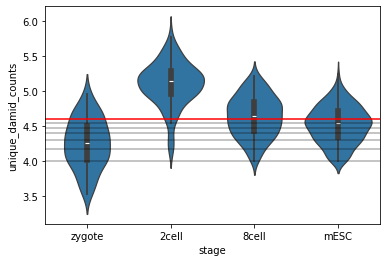

In [29]:
select_ind = ((anno.genotype=='homozygous') | (anno.stage=='mESC')) & (anno.treatment=='no_treatment')
select_thresh = 40000

anno_select = anno[select_ind].copy()
n_conditions = len(list(anno_select.groupby(['stage', 'genotype', 'treatment'])))
anno_select['stage'] = pd.Categorical(anno_select['stage'], categories=stage_order)
anno_select['treatment'] = pd.Categorical(anno_select['treatment'], categories=treatment_order)
anno_select['label'] = anno_select.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))
label_order = anno_select.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

fig, ax = plt.subplots()
sns.violinplot(x=anno_select['stage'], y=np.log10(anno_select['unique_damid_counts']))

for y in downsample_threshold_ls:
    if y == select_thresh:
        ax.axhline(np.log10(y), c='r')
    else:
        ax.axhline(np.log10(y), c='k', alpha=.3)
        
anno_select[anno_select.unique_damid_counts > select_thresh].groupby('stage').size()

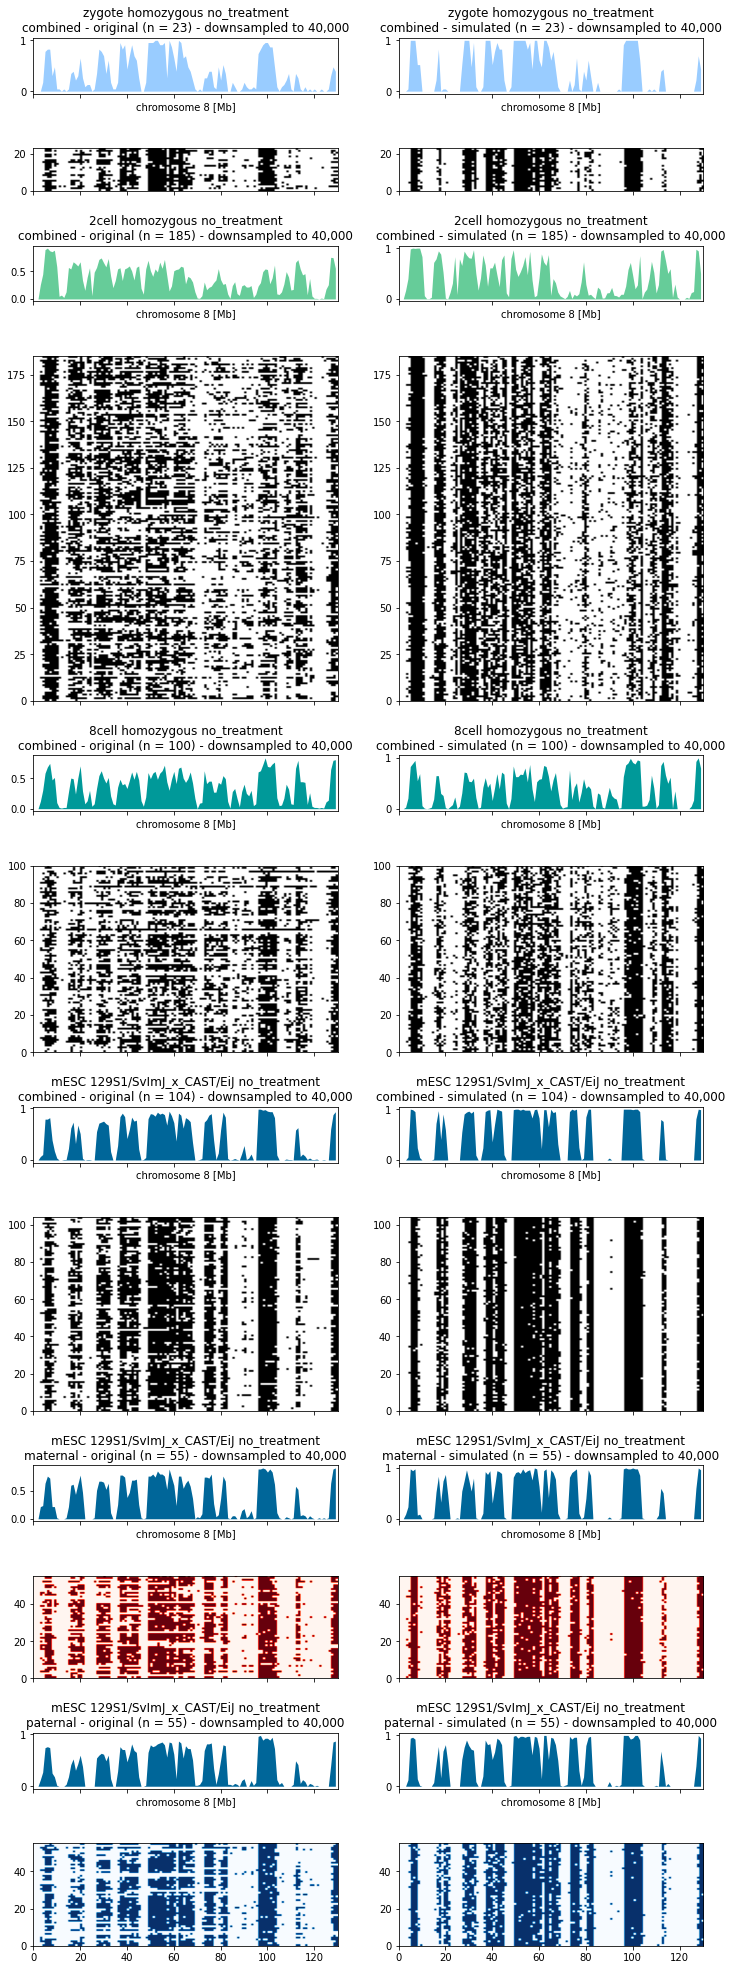

In [30]:
chrom = '8'
plot_real_and_simulated_data(anno_select, chrom, plot_downsampled=True, downtarget=select_thresh)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


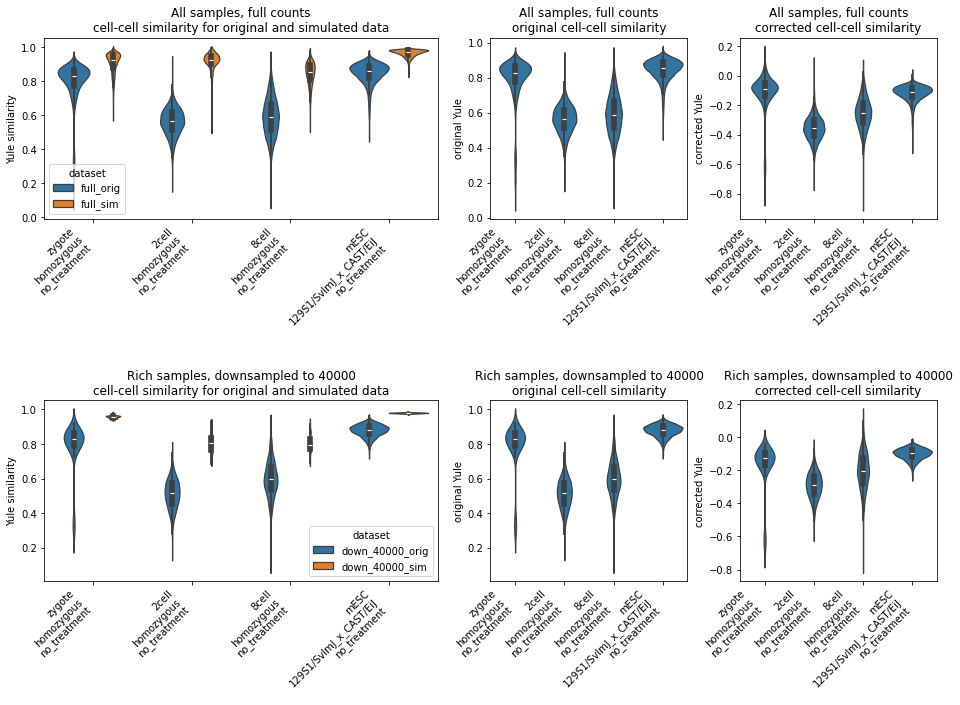

In [31]:
metric = 'Yule'
allele = 'combined'
plot_similarity_scores(anno_select, select_thresh, metric, allele)

## 3.4 Inspect results: F1xCAST 2-cell samples

### Step 1: Determine appropriate downsampling depth

stage  treatment       unique_damid_counts
2cell  no_treatment    False                   7
                       True                   19
       Lap2b           False                   2
                       True                    9
       Cbx7(CD)-Lap2b  True                   39
dtype: int64

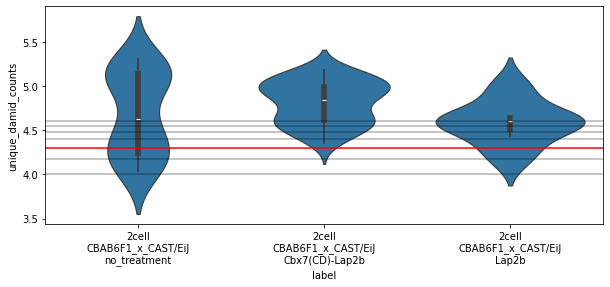

In [177]:
select_ind = anno.stage.isin(['2cell']) & (anno.genotype=='CBAB6F1_x_CAST/EiJ')
select_thresh = 20000

anno_select = anno[select_ind].copy()
n_conditions = len(list(anno_select.groupby(['stage', 'genotype', 'treatment'])))
anno_select['stage'] = pd.Categorical(anno_select['stage'], categories=stage_order)
anno_select['treatment'] = pd.Categorical(anno_select['treatment'], categories=treatment_order)
anno_select['label'] = anno_select.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))
label_order = anno_select.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(x=anno_select['label'], y=np.log10(anno_select['unique_damid_counts']))

for y in downsample_threshold_ls:
    if y == select_thresh:
        ax.axhline(np.log10(y), c='r')
    else:
        ax.axhline(np.log10(y), c='k', alpha=.3)
        
df = anno_select.groupby(['stage', 'treatment', anno_select.unique_damid_counts > select_thresh]).size()
df[df>0]

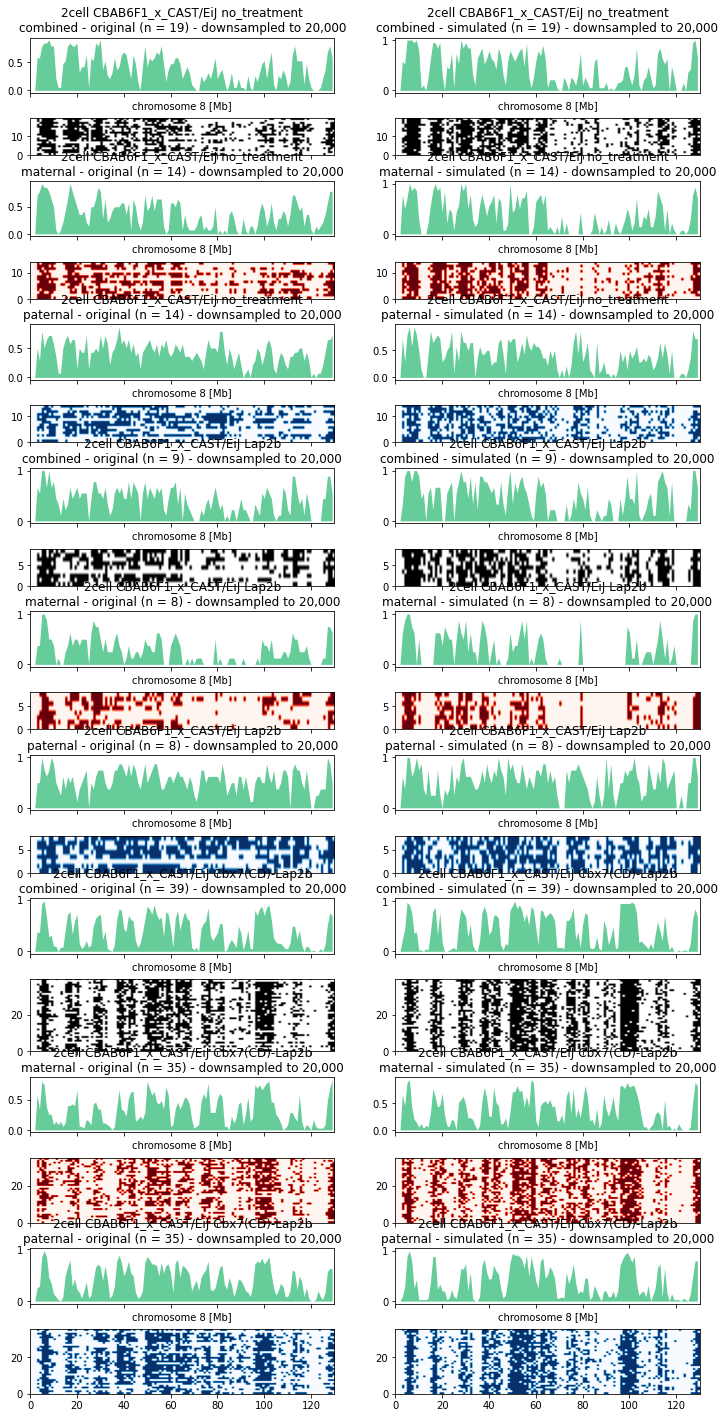

In [181]:
chrom = '8'
plot_real_and_simulated_data(anno_select, chrom, plot_downsampled=True, downtarget=select_thresh)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


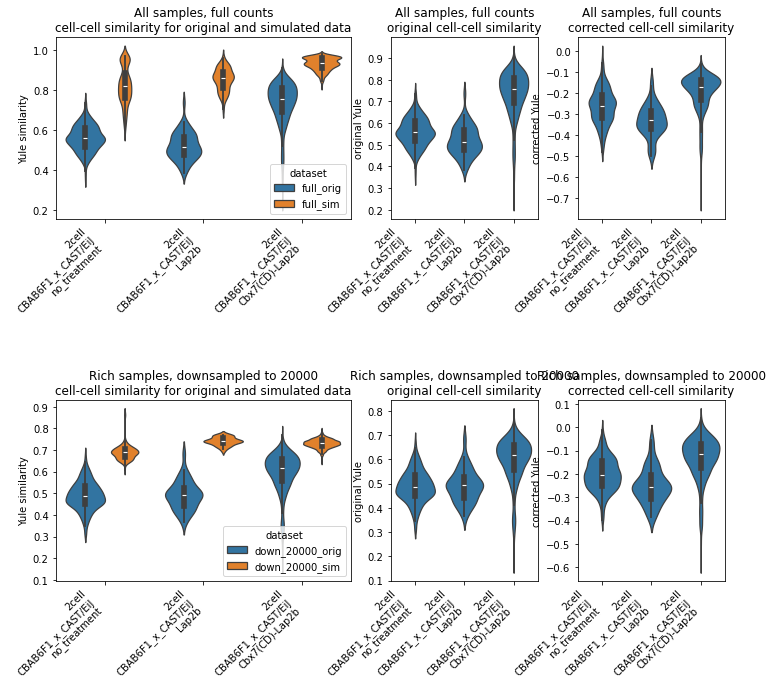

In [34]:
metric = 'Yule'
allele = 'combined'
plot_similarity_scores(anno_select, select_thresh, metric, allele)

## 3.5 Inspect results: F1xCAST 8-cell samples

### Step 1: Determine appropriate downsampling depth

stage  treatment       unique_damid_counts
8cell  no_treatment    True                   21
       Cbx7(CD)-Lap2b  True                   35
dtype: int64

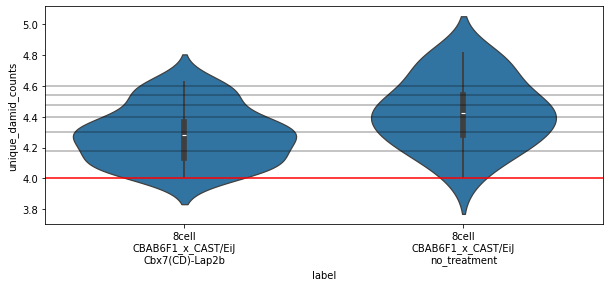

In [35]:
select_ind = anno.stage.isin(['8cell']) & (anno.genotype=='CBAB6F1_x_CAST/EiJ')
select_thresh = 10000

anno_select = anno[select_ind].copy()
n_conditions = len(list(anno_select.groupby(['stage', 'genotype', 'treatment'])))
anno_select['stage'] = pd.Categorical(anno_select['stage'], categories=stage_order)
anno_select['treatment'] = pd.Categorical(anno_select['treatment'], categories=treatment_order)
anno_select['label'] = anno_select.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))
label_order = anno_select.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(x=anno_select['label'], y=np.log10(anno_select['unique_damid_counts']))

for y in downsample_threshold_ls:
    if y == select_thresh:
        ax.axhline(np.log10(y), c='r')
    else:
        ax.axhline(np.log10(y), c='k', alpha=.3)
        
df = anno_select.groupby(['stage', 'treatment', anno_select.unique_damid_counts > select_thresh]).size()
df[df>0]

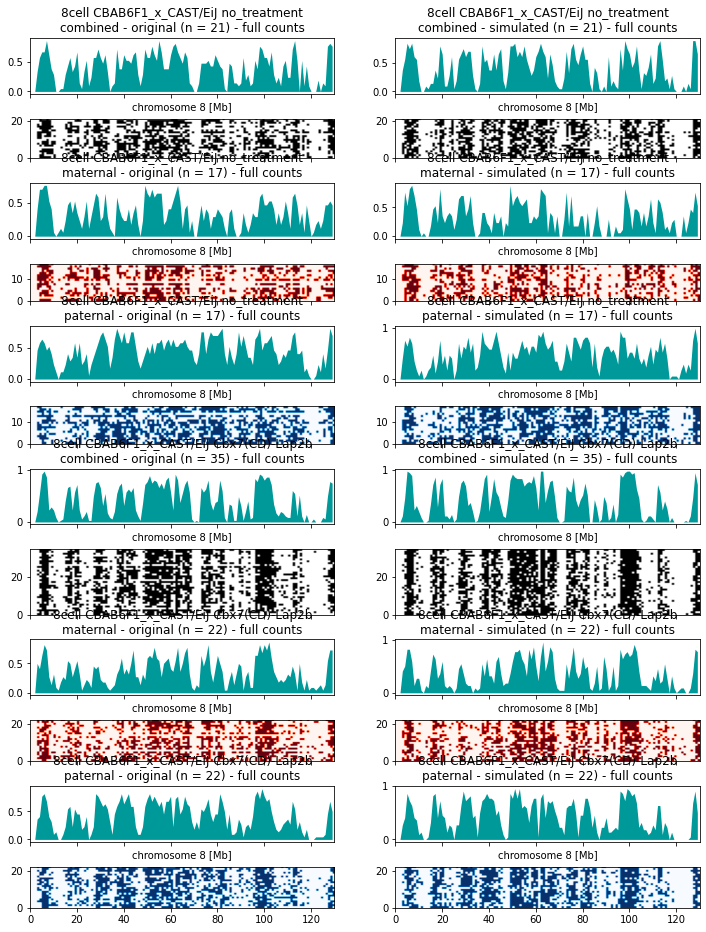

In [36]:
chrom = '8'
plot_real_and_simulated_data(anno_select, chrom, plot_downsampled=False, downtarget=select_thresh)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


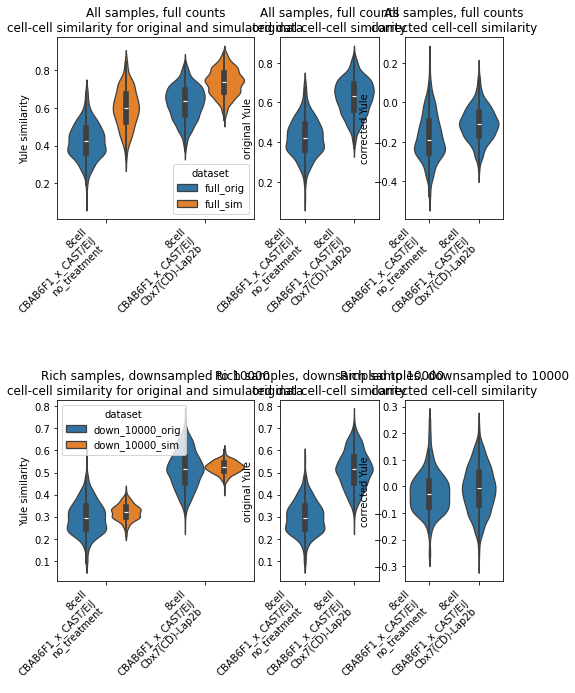

In [37]:
metric = 'Yule'
allele = 'combined'
plot_similarity_scores(anno_select, select_thresh, metric, allele)

## 3.6 Inspect results: EED samples

### Step 1: Determine appropriate downsampling depth

In [38]:
anno.columns

Index(['runid', 'illumina_index', 'damid2_adapter_number',
       'celseq2_adapter_number', 'cellcount', 'construct', 'fusion_construct',
       'stage', 'treatment', 'genotype', 'system', 'number_embryos',
       'rna_conc_nguL', 'cycle_phase', 'induction_system', 'induction_timing',
       'additional_construct', 'is_heterozygous', 'technique', 'embryo_id',
       'sex', 'damid_name', 'celseq_name', 'unique_damid_counts',
       'maternal_damid_counts', 'paternal_damid_counts', 'IC_mappability',
       'allelic_damid_balance', 'nGenes', 'nTranscripts',
       'nTranscripts_maternal', 'nTranscripts_paternal',
       'allelic_celseq_balance', 'nERCC', 'nMito', 'DamID_PASS',
       'DamID_PASS_allelic', 'CELseq_PASS', 'stage_order'],
      dtype='object')

stage  treatment  unique_damid_counts
2cell  EED_ctrl   False                  33
                  True                   54
       EED_mKO    False                  16
                  True                   38
dtype: int64

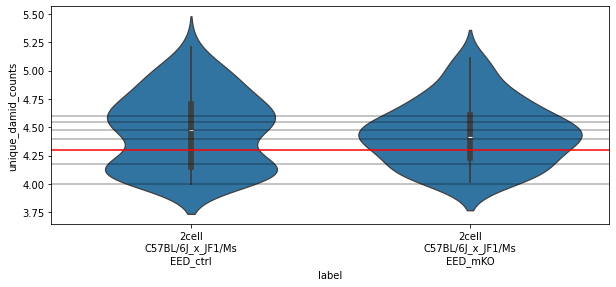

In [39]:
select_ind = (anno.treatment.str.contains('EED'))
select_thresh = 20000

anno_select = anno[select_ind].copy()
n_conditions = len(list(anno_select.groupby(['stage', 'genotype', 'treatment'])))
anno_select['stage'] = pd.Categorical(anno_select['stage'], categories=stage_order)
anno_select['treatment'] = pd.Categorical(anno_select['treatment'], categories=treatment_order)
anno_select['label'] = anno_select.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))
label_order = anno_select.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(x=anno_select['label'], y=np.log10(anno_select['unique_damid_counts']))

for y in downsample_threshold_ls:
    if y == select_thresh:
        ax.axhline(np.log10(y), c='r')
    else:
        ax.axhline(np.log10(y), c='k', alpha=.3)
        
df = anno_select.groupby(['stage', 'treatment', anno_select.unique_damid_counts > select_thresh]).size()
df[df>0]

stage  treatment  unique_damid_counts
2cell  EED_ctrl   False                  33
                  True                   54
       EED_mKO    False                  16
                  True                   38
dtype: int64

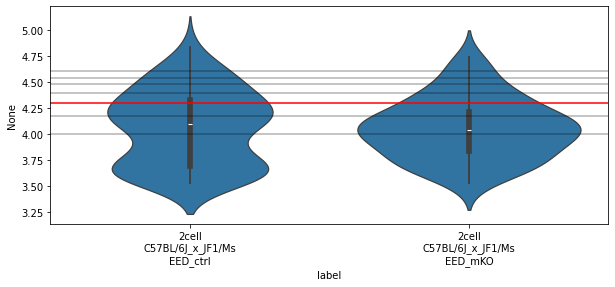

In [40]:
fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(x=anno_select['label'], y=np.log10(anno_select[['maternal_damid_counts','paternal_damid_counts']].sum(axis=1)))

for y in downsample_threshold_ls:
    if y == select_thresh:
        ax.axhline(np.log10(y), c='r')
    else:
        ax.axhline(np.log10(y), c='k', alpha=.3)
        
df = anno_select.groupby(['stage', 'treatment', anno_select.unique_damid_counts > select_thresh]).size()
df[df>0]

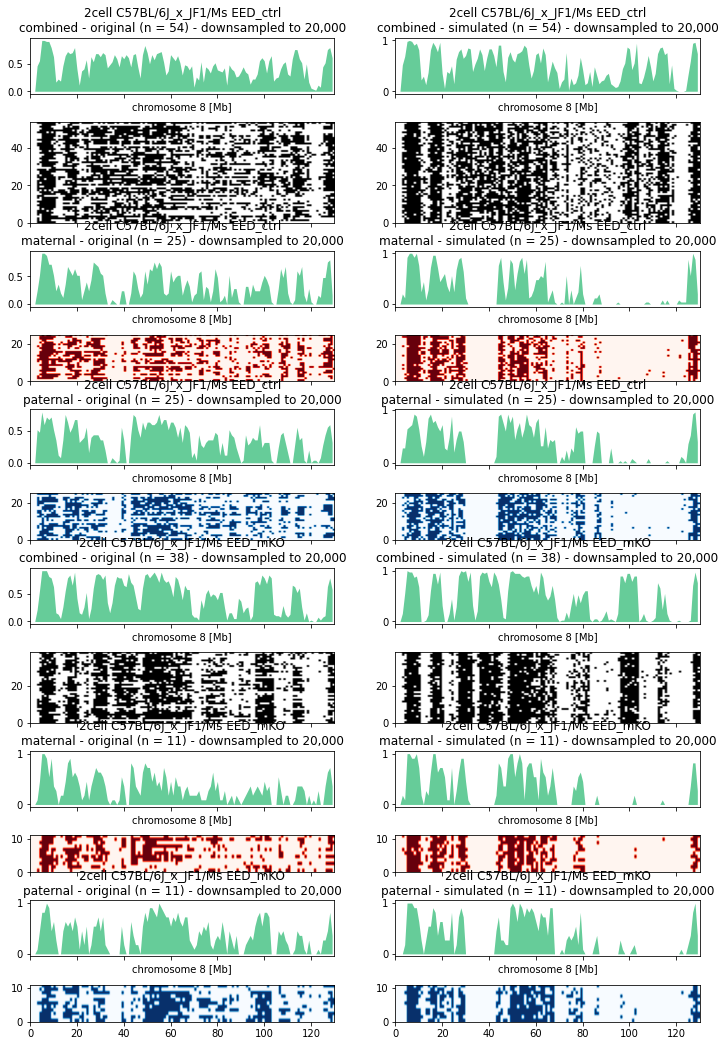

In [41]:
chrom = '8'
plot_real_and_simulated_data(anno_select, chrom, plot_downsampled=True, downtarget=select_thresh)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


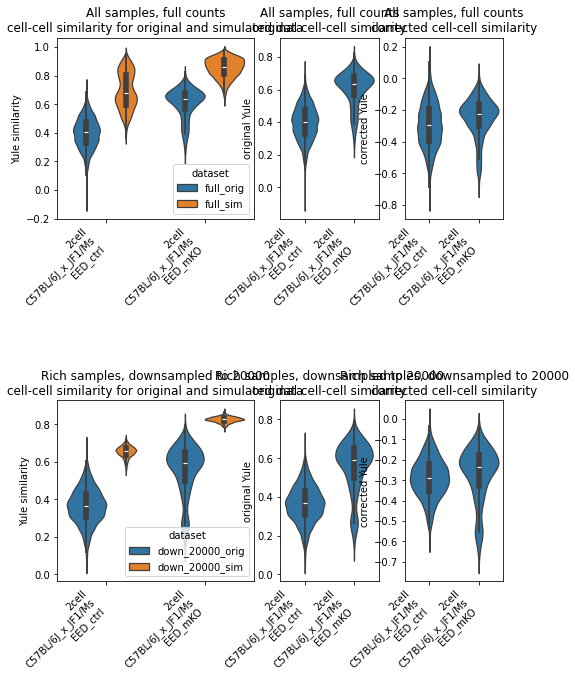

In [42]:
metric = 'Yule'
allele = 'combined'
plot_similarity_scores(anno_select, select_thresh, metric, allele)

## 3.7 Inspect results: Homozygous Cbx7-Lap2b experiment

### Step 1: Determine appropriate downsampling depth

stage  treatment       unique_damid_counts
2cell  no_treatment    True                   197
       Lap2b           True                    31
       Cbx7(CD)-Lap2b  True                    28
dtype: int64

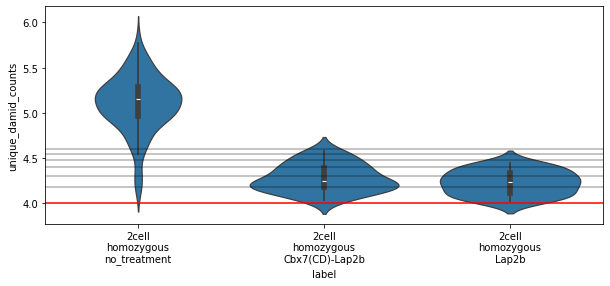

In [43]:
select_ind = (anno.stage=='2cell') & (anno.genotype=='homozygous') & anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b'])
select_thresh = 10000

anno_select = anno[select_ind].copy()
n_conditions = len(list(anno_select.groupby(['stage', 'genotype', 'treatment'])))
anno_select['stage'] = pd.Categorical(anno_select['stage'], categories=stage_order)
anno_select['treatment'] = pd.Categorical(anno_select['treatment'], categories=treatment_order)
anno_select['label'] = anno_select.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))
label_order = anno_select.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(x=anno_select['label'], y=np.log10(anno_select['unique_damid_counts']))

for y in downsample_threshold_ls:
    if y == select_thresh:
        ax.axhline(np.log10(y), c='r')
    else:
        ax.axhline(np.log10(y), c='k', alpha=.3)
        
df = anno_select.groupby(['stage', 'treatment', anno_select.unique_damid_counts > select_thresh]).size()
df[df>0]

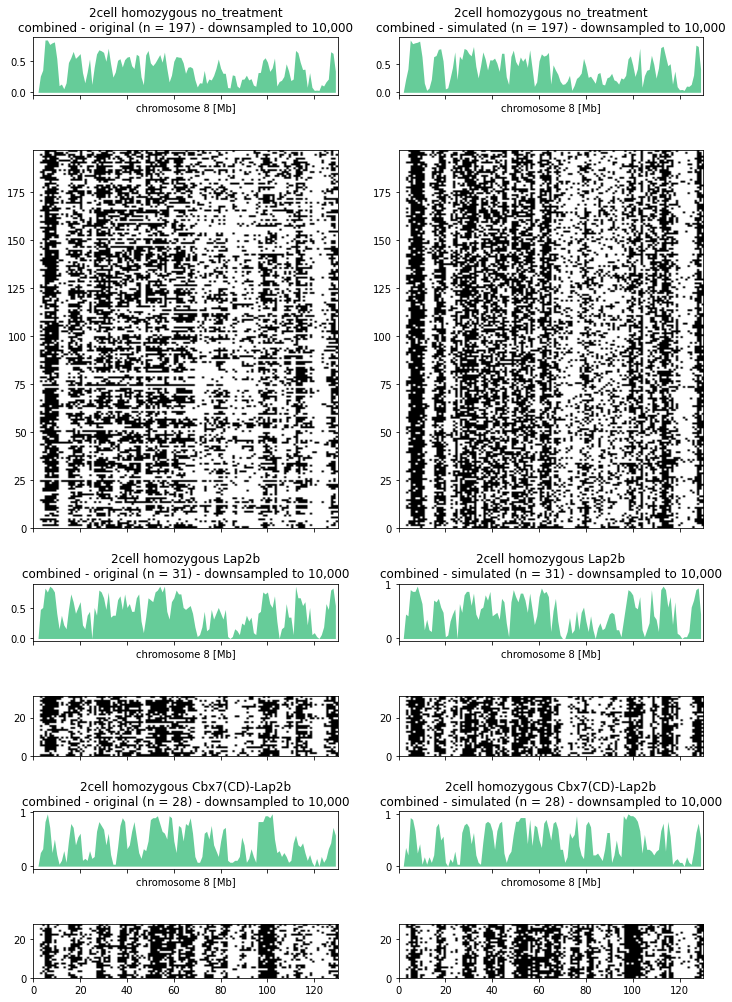

In [44]:
chrom = '8'
plot_real_and_simulated_data(anno_select, chrom, plot_downsampled=True, downtarget=select_thresh)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/1552114666.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


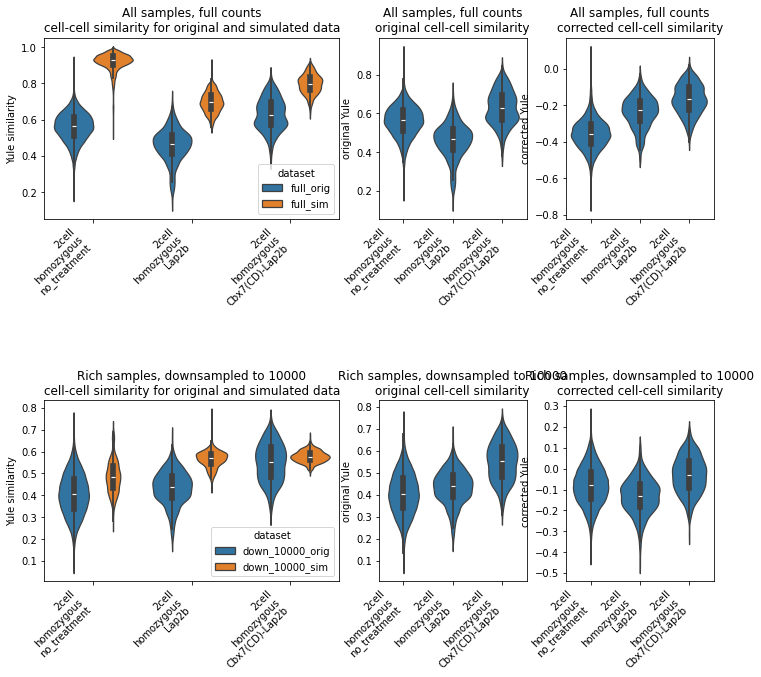

In [45]:
metric = 'Yule'
allele = 'combined'
plot_similarity_scores(anno_select, select_thresh, metric, allele)

## 3.8 Compare variability on chrX to somatic chromosomes - 2cell conditions

In [207]:
metric = 'Yule'
subsample = 'down_10000'
condition_ls = [info for info, _ in anno[(anno.stage=='2cell')&(anno.is_heterozygous)].groupby(['stage','genotype','treatment'])]

# collect relevant data
to_plot = list()
dataselect_ls = [subsample+'_orig', subsample+'_sim']

for condition in condition_ls:
    for ds in dataselect_ls:
        for chrom in ['somatic', 'X']:
            
            if chrom == 'X':
                df = chrom_pairwise_similarity_scores[condition].copy()
                ind = (df['sample1'] != df['sample2']) & (df['metric'] == metric) & (df['dataset'] == ds)
                ind2 = df['allele'].isin(['maternal','paternal'])
                ind3 = (df['chrom'] == 'X')
                ind = ind & ind2 & ind3
                df = df[ind]
                df.loc[df.chrom=='X','chrom'] = df[df.chrom=='X'].apply(axis=1, func = lambda r: 'X_%s' % r['sex'])
            else:
                df = pairwise_similarity_scores[condition].copy()
                ind = (df['sample1'] != df['sample2']) & (df['metric'] == metric) & (df['dataset'] == ds)
                ind2 = df['allele'].isin(['maternal','paternal'])
                ind = ind & ind2
                df = df[ind]
                df['chrom'] = 'somatic'
                
            df = df[['sample1', 'sample2', 'similarity', 'dataset', 'allele', 'chrom']]
            df['stage'] = condition[0]
            df['genotype'] = condition[1]
            df['treatment'] = condition[2]
            to_plot.append(df)

to_plot = pd.concat(to_plot, axis=0)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6910/3537562534.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6910/3537562534.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6910/3537562534.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6910/3537562534.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6910/3537562534.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


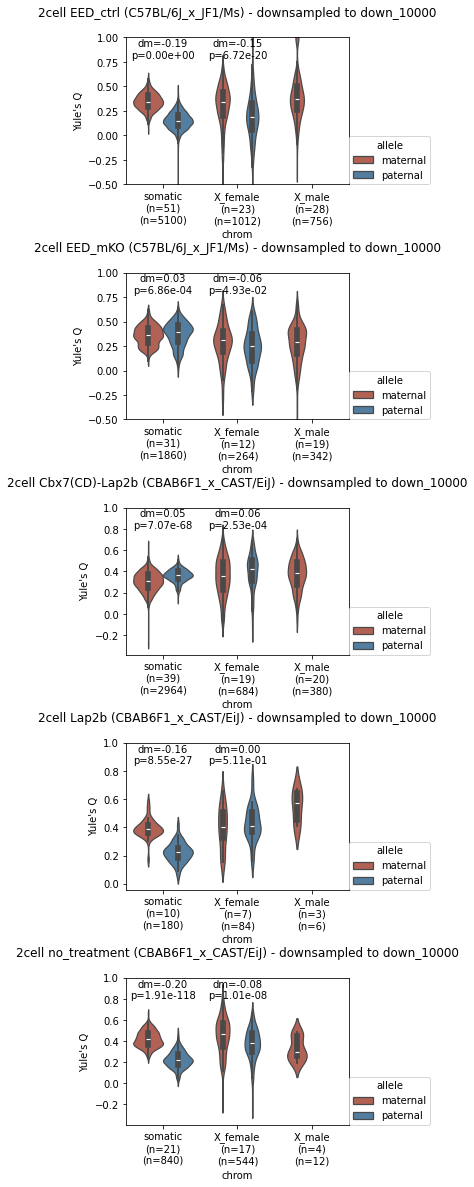

In [211]:
# set up plot
nplot = len(condition_ls)
ncol = 1
nrow = int(np.ceil(nplot/ncol))
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
plt.subplots_adjust(hspace=0.6)
irow = -1

# plot results
for info, df in to_plot.groupby(['stage', 'genotype', 'treatment']):
    irow += 1

    ## unstacking data
    df = df.copy().drop(columns=['stage', 'genotype', 'treatment'])
    df = df.set_index(['chrom', 'allele', 'sample1', 'sample2', 'dataset']).unstack()
    df.columns = [c[1].split('_')[-1] for c in df.columns.values]
    df = df.reset_index()
    df['corrected'] = df['orig'] - df['sim']
    df = df[~((df.chrom=='X_male')&(df.allele=='paternal'))]

    # determining xticklabels
    xlabs = []
    for c in ['somatic', 'X_female', 'X_male']:
        n1 = len(set(df.loc[df.chrom==c,'sample1'].unique()) | set(df.loc[df.chrom==c,'sample2'].unique()))
        n2 = (df.chrom==c).sum()
        xlabs.append('%s\n(n=%d)\n(n=%d)'%(c,n1,n2))
        
    # plot 
    ax = axes.flatten()[irow]
    sns.violinplot(
        x=df['chrom'], y=df['orig'], hue=df['allele'], order=['somatic', 'X_female', 'X_male'], 
        palette=color_dict['allele'], ax=ax)
    
    # stat test
    for x, chrom in enumerate(['somatic', 'X_female', 'X_male']):
        A = df.loc[(df.chrom==chrom)&(df.allele=='maternal'),'orig'].values
        B = df.loc[(df.chrom==chrom)&(df.allele=='paternal'),'orig'].values
        if len(B) == 0:
            continue
        assert len(A)==len(B)
        dm = np.median(B) - np.median(A)
        s, p = stats.mannwhitneyu(A, B)
        ax.text(x, 0.99, 'dm=%.2f\np=%.2e'%(dm,p), ha='center', va='top')
    
    # format plot
    ax.set_xticklabels(xlabs)
    ax.set_ylabel('Yule\'s Q')
    ymin = max(-0.5, ax.get_ylim()[0])
    ymax =  1 #min(1, ax.get_ylim()[1])
    ax.set_ylim(ymin,ymax)
    ax.legend(loc=(1,0),title='allele')
    ax.set_title('%s %s (%s) - downsampled to %s\n' % (info[0], info[2], info[1], subsample))
    
outfmt = FIGOUTDIR + 'chrX_vs_somatic.similarity_scores.between_2cell_conditions.original_YulesQ.down_10000.binsize_{binsize:d}.pdf'
outfn = outfmt.format(binsize=BINSIZE)
plt.savefig(outfn, bbox_inches='tight')

# 4. Making nice plots

## 4.1 Function to collect statistical results

In [46]:
import itertools

In [47]:
def statistical_results_between_conditions(to_plot, plot_col):
    stat_dict = defaultdict(list)
    condition_ls = [info for info, _ in anno_select.groupby(['stage', 'genotype', 'treatment'])]

    for cond1, cond2 in itertools.combinations(condition_ls, 2):

        for i, cond in enumerate([cond1,cond2]):
            i += 1
            stat_dict['stage_%d'%i].append(cond[0])
            stat_dict['genotype_%d'%i].append(cond[1])
            stat_dict['treatment_%d'%i].append(cond[2])
            ind = (to_plot['stage']==cond[0])&(to_plot['genotype']==cond[1])&(to_plot['treatment']==cond[2])
            tmp = np.concatenate([to_plot.loc[ind,'sample1'].values, to_plot.loc[ind,'sample2'].values])
            stat_dict['n_samples_%d'%i].append(len(np.unique(tmp)))
            stat_dict['n_sample_pairs_%d'%i].append(ind.sum())

        
        ind1 = (to_plot['stage']==cond1[0])&(to_plot['genotype']==cond1[1])&(to_plot['treatment']==cond1[2])
        ind2 = (to_plot['stage']==cond2[0])&(to_plot['genotype']==cond2[1])&(to_plot['treatment']==cond2[2])
        A = to_plot.loc[ind1,plot_col].values
        B = to_plot.loc[ind2,plot_col].values
        
        stat_dict['median_1'].append(np.median(A))
        stat_dict['mean_1'].append(A.mean())
        stat_dict['std_1'].append(np.std(A))
        
        stat_dict['median_2'].append(np.median(B))
        stat_dict['mean_2'].append(B.mean())
        stat_dict['std_2'].append(np.std(B))
        
        s, p = stats.mannwhitneyu(A, B)
        stat_dict['MannWhitneyU_stat'].append(s)
        stat_dict['MannWhitneyU_pval'].append(p)
        
    stat_df = pd.DataFrame(stat_dict)
    return stat_df

## 4.2 Function to adjust y-limit to exclude outliers

In [48]:
def define_ylim(to_plot, groupcol, plot_col, current_ylim, n_std=5):

    min_ls = list()
    max_ls = list()
    
    for cat, df in to_plot.groupby(groupcol):
        
        m = np.mean(df[plot_col])
        s = np.std(df[plot_col])
        
        min_ls.append(m-n_std*s)
        max_ls.append(m+n_std*s)
        
    mn = max(min(min_ls),current_ylim[0])
    mx = min(max(max_ls),current_ylim[1])
    
    return (mn, mx)
        

## 4.3 Function to plot results

In [49]:
def plot_nice_similarity_scores(anno_select, metric, allele, plot_downsampled, select_thresh, plot_col, color_by=''):
    
    assert plot_col in ['original', 'simulated', 'corrected']
    if len(color_by):
        assert color_by in ['stage', 'treatment']
    
    # determine number and order of conditions
    anno_select['label'] = anno_select.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))
    anno_select['stage'] = pd.Categorical(anno_select['stage'], categories=stage_order)
    anno_select['treatment'] = pd.Categorical(anno_select['treatment'], categories=treatment_order)
    n_conditions = len(list(anno_select.groupby(['stage', 'genotype', 'treatment'])))
    label_order = anno_select.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

    # collect relevant data
    to_plot = list()
    if plot_downsampled:
        assert select_thresh in downsample_threshold_ls
        dataselect_ls = ['down_%s_orig' % select_thresh, 'down_%s_sim' % select_thresh]
    else:
        dataselect_ls = ['full_orig', 'full_sim']

    for ds in dataselect_ls:

        for info, _ in anno_select.groupby(['stage', 'genotype', 'treatment']):

            df = pairwise_similarity_scores[info].copy()
            ind = (df['sample1'] != df['sample2']) & (df['allele'] == allele) & (df['metric'] == metric) & (df['dataset'] == ds)
            df = df[ind]
            for col in ['stage', 'genotype', 'treatment', 'label']:
                df[col] = anno_select.loc[df.sample1.values,col].values
            df['dataset'] = df['dataset'].apply(func = lambda d: 'original' if 'orig' in d else 'simulated')

            to_plot.append(df)

    to_plot = pd.concat(to_plot, axis=0)
    
    
    to_plot = to_plot.drop(columns=['metric', 'allele'])
    to_plot = to_plot.set_index(['label', 'stage', 'genotype', 'treatment', 'sample1', 'sample2', 'dataset']).unstack()
    to_plot.columns = [c[1] for c in to_plot.columns.values]
    to_plot = to_plot.reset_index()
    to_plot['corrected'] = to_plot['original'] - to_plot['simulated']
    to_plot['sample_pair'] = to_plot.apply(axis=1, func=lambda r: ':'.join(sorted([r['sample1'], r['sample2']])))
    ind = to_plot['sample_pair'].duplicated()
    assert ind.mean() == 0.5
    to_plot = to_plot[~ind]
    
    
    # set up plot
    fig, ax = plt.subplots(figsize=(n_conditions, 4))

    ## plot original
    if len(color_by) > 0:
        sns.violinplot(
            x=to_plot['label'], y=to_plot[plot_col], hue=to_plot[color_by], 
            order=label_order, ax=ax, dodge=False, palette=color_dict[color_by]
        )
        ax.legend(loc=(1,0), title=color_by)
    else:
        sns.violinplot(x=to_plot['label'], y=to_plot[plot_col], order=label_order, ax=ax)
        
    # format plot
    ax.set_ylabel('%s %s' % (plot_col, metric))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    
    if plot_downsampled:
        t = 'cell-to-cell similarity - {} allele\n{} data - downsampled to {:,} counts'.format(allele, plot_col, select_thresh)
    else:
        t = 'cell-to-cell similarity - {} allele\n{} data - Full data'.format(allele, plot_col)
    ax.set_title(t)
    
    # adjust yrange to exclude outliers
    newlim = define_ylim(to_plot, 'label', plot_col, ax.get_ylim())
    ax.set_ylim(newlim)
    
    # collect stistical information
    stat_df = statistical_results_between_conditions(to_plot, plot_col)
    stat_df['allele'] = allele
    stat_df['metric'] = metric
    if plot_downsampled:
        stat_df['downsampled_to'] = select_thresh
    stat_df['dataset'] = plot_col
    
    return stat_df

## 4.4 Plot results per experiment

In [50]:
plot_settings = {
    'EED_mKO_vs_WT': {
        'select_ind': anno.treatment.str.contains('EED'),
        'select_thresh': 20000,
        'color_by': 'treatment'
    },
    
    'homozygous_untreated': {
        'select_ind': ((anno.genotype == 'homozygous')|(anno.stage=='mESC')) & (anno.treatment=='no_treatment'),
        'select_thresh': 40000,
        'color_by': 'stage'
    },
    
    'homozygous_2cell_Cbx7-Lap2b': {
        'select_ind': (anno.stage=='2cell') & (anno.genotype == 'homozygous') & (anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b'])),
        'select_thresh': 10000,
        'color_by': 'treatment'
    },
    
    'hybrid_2cell_Cbx7-Lap2b': {
        'select_ind': (anno.stage=='2cell') & (anno.genotype == 'CBAB6F1_x_CAST/EiJ') & (anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b'])),
        'select_thresh': 20000,
        'color_by': 'treatment'
    },
    
    'hybrid_8cell_Cbx7-Lap2b': {
        'select_ind': (anno.stage=='8cell') & (anno.genotype == 'CBAB6F1_x_CAST/EiJ') & (anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b'])),
        'select_thresh': 10000,
        'color_by': 'treatment'
    },
    
    'hybrid_all_Cbx7-Lap2b': {
        'select_ind': (anno.stage.isin(['2cell', '8cell'])) & (anno.genotype == 'CBAB6F1_x_CAST/EiJ') & (anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b'])),
        'select_thresh': 20000,
        'color_by': 'treatment'
    }
    
}

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/3461389497.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


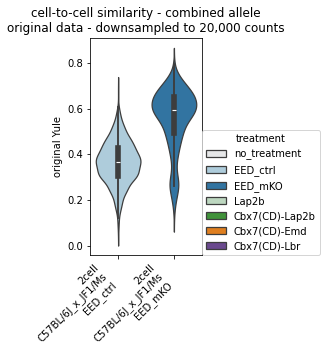

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/3461389497.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


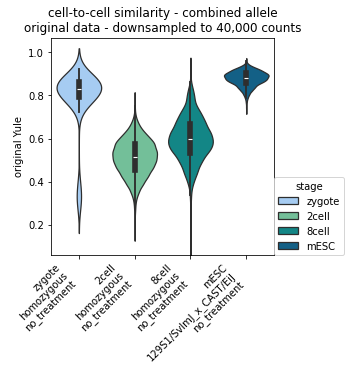

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/3461389497.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


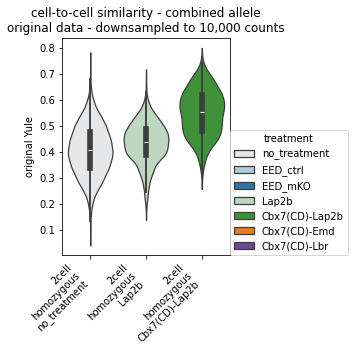

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/3461389497.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


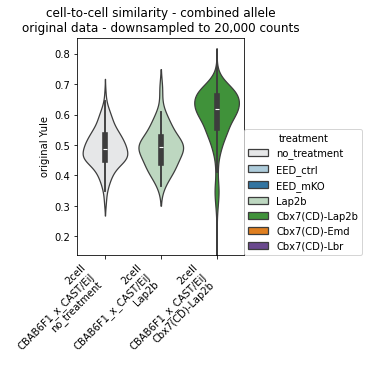

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/3461389497.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


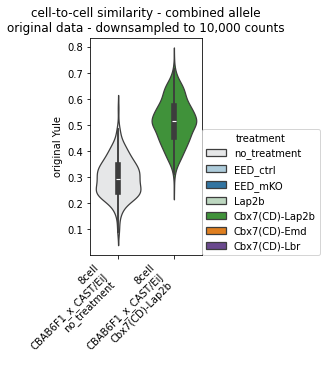

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/3461389497.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


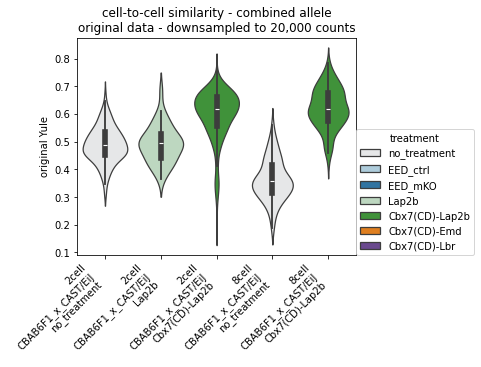

In [51]:
outfmt = 'similarity_scores.between_conditions.{title}.{dataset}_{metric}.{downsample}.binsize_{binsize:d}.pdf'

for title in plot_settings:
    
    anno_select = anno[plot_settings[title]['select_ind']].copy()
    metric = 'Yule'
    allele = 'combined'
    plot_downsampled = True
    select_thresh = plot_settings[title]['select_thresh']
    color_by = plot_settings[title]['color_by']
    
    stat_df = plot_nice_similarity_scores(
        anno_select, metric, allele, plot_downsampled, select_thresh, 'original', color_by
    )
    
    if plot_downsampled:
        tmp = 'downsampled_to_%d' % select_thresh
    else:
        tmp = 'full_data'
    outfn = FIGOUTDIR + outfmt.format(title=title, dataset='original', metric=metric, downsample=tmp, binsize=BINSIZE)
    plt.savefig(outfn, bbox_inches='tight')
    
    outfn = outfn.replace('pdf', 'stats.tsv')
    stat_df.to_csv(outfn, sep='\t', header=True, index=False)
    
    plt.show()
    plt.close()

In [52]:
def plot_nice_similarity_scores_allelic(anno_select, metric, plot_downsampled, select_thresh, plot_col):
    
    assert plot_col in ['original', 'simulated', 'corrected']
    if len(color_by):
        assert color_by in ['stage', 'treatment']
    
    # determine number and order of conditions
    anno_select = anno_select[anno_select.is_heterozygous]
    if len(anno_select) == 0:
        return
    anno_select['label'] = anno_select.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))
    anno_select['stage'] = pd.Categorical(anno_select['stage'], categories=stage_order)
    anno_select['treatment'] = pd.Categorical(anno_select['treatment'], categories=treatment_order)
    n_conditions = len(list(anno_select.groupby(['stage', 'genotype', 'treatment'])))
    label_order = anno_select.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

    # collect relevant data
    to_plot = list()
    if plot_downsampled:
        assert select_thresh in downsample_threshold_ls
        dataselect_ls = ['down_%s_orig' % select_thresh, 'down_%s_sim' % select_thresh]
    else:
        dataselect_ls = ['full_orig', 'full_sim']

    for ds in dataselect_ls:

        for info, _ in anno_select.groupby(['stage', 'genotype', 'treatment']):

            df = pairwise_similarity_scores[info].copy()
            ind = (df['sample1'] != df['sample2']) & (df['allele'].isin(['maternal', 'paternal'])) & (df['metric'] == metric) & (df['dataset'] == ds)
            df = df[ind]
            for col in ['stage', 'genotype', 'treatment', 'label']:
                df[col] = anno_select.loc[df.sample1.values,col].values
            df['dataset'] = df['dataset'].apply(func = lambda d: 'original' if 'orig' in d else 'simulated')

            to_plot.append(df)

    to_plot = pd.concat(to_plot, axis=0)
    
    
    to_plot = to_plot.drop(columns=['metric'])
    to_plot = to_plot.set_index(['label', 'stage', 'genotype', 'treatment', 'allele', 'sample1', 'sample2', 'dataset']).unstack()
    to_plot.columns = [c[1] for c in to_plot.columns.values]
    to_plot = to_plot.reset_index()
    to_plot['corrected'] = to_plot['original'] - to_plot['simulated']
    to_plot['sample_pair'] = to_plot.apply(axis=1, func=lambda r: ':'.join(sorted([r['sample1'], r['sample2']])))
    ind = to_plot[['sample_pair','allele']].duplicated()
    assert ind.mean() == 0.5
    to_plot = to_plot[~ind]
    
    
    # set up plot
    fig, ax = plt.subplots(figsize=(n_conditions, 4))

    ## plot original
    sns.violinplot(
        x=to_plot['label'], y=to_plot[plot_col], hue=to_plot['allele'], 
        order=label_order, ax=ax, dodge=True, palette=color_dict['allele']
    )
    ax.legend(loc=(1,0), title='allele')
        
    # format plot
    ax.set_ylabel('%s %s' % (plot_col, metric))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    
    if plot_downsampled:
        t = 'cell-to-cell similarity\n{} data - downsampled to {:,} counts'.format(plot_col, select_thresh)
    else:
        t = 'cell-to-cell similarity\n{} data - Full data'.format(plot_col)
    ax.set_title(t)
    
    # adjust yrange to exclude outliers
    newlim = define_ylim(to_plot, 'label', plot_col, ax.get_ylim())
    ax.set_ylim(newlim)
    
    # collect stistical information
    stat_ls = list()
    for allele in ['maternal', 'paternal']:
        stat_df = statistical_results_between_conditions(to_plot[to_plot['allele']==allele], plot_col)
        stat_df['allele'] = allele
        stat_df['metric'] = metric
        if plot_downsampled:
            stat_df['downsampled_to'] = select_thresh
        stat_df['dataset'] = plot_col
        stat_ls.append(stat_df)
    stat_df = pd.concat(stat_ls, axis=0).reset_index(drop=True)
    
    return stat_df

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/2724352348.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


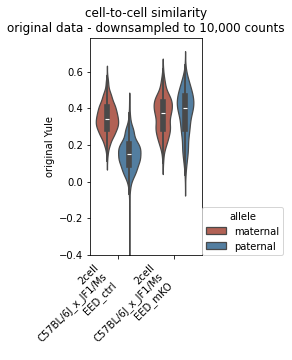

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/2724352348.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


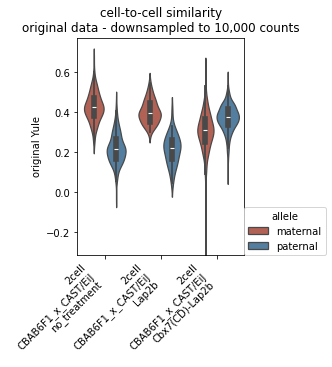

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/2724352348.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


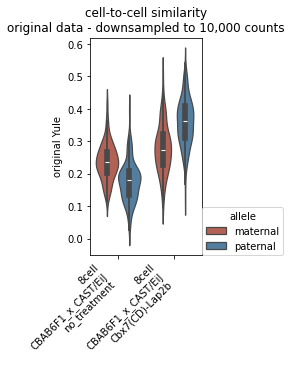

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_41029/2724352348.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


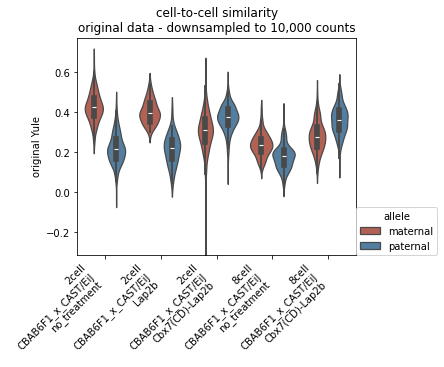

In [53]:
outfmt = 'similarity_scores.between_conditions.alleles_separated.{title}.{dataset}_{metric}.{downsample}.binsize_{binsize:d}.pdf'

for title in plot_settings:
    
    anno_select = anno[plot_settings[title]['select_ind']].copy()
    anno_select = anno_select[anno_select.is_heterozygous]
    if len(anno_select) == 0:
        continue
    if len(list(anno_select.groupby(['stage', 'genotype', 'treatment']))) == 1:
        continue
    metric = 'Yule'
    plot_downsampled = True
    select_thresh = 10000

    stat_df = plot_nice_similarity_scores_allelic(
        anno_select, metric, plot_downsampled, select_thresh, 'original'
    )
    
    if plot_downsampled:
        tmp = 'downsampled_to_%d' % select_thresh
    else:
        tmp = 'full_data'
    outfn = FIGOUTDIR + outfmt.format(title=title, dataset='original', metric=metric, downsample=tmp, binsize=BINSIZE)
    plt.savefig(outfn, bbox_inches='tight')
    
    outfn = outfn.replace('pdf', 'stats.tsv')
    stat_df.to_csv(outfn, sep='\t', header=True, index=False)
    
    plt.show()
    plt.close()

# 5. Comparison between same and different embryo

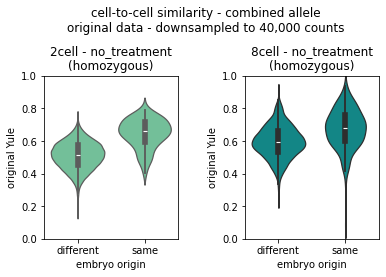

In [54]:
ind = anno.stage.isin(['2cell','8cell']) & (anno.genotype=='homozygous') & (anno.treatment == 'no_treatment')
anno_select = anno[ind].copy()
plot_downsampled = True
plot_col = 'original'
select_thresh = 40000
allele == 'combined'
metric = 'Yule'

fig, axes = plt.subplots(1,2, figsize=(6,3))
plt.subplots_adjust(wspace=.5)
counter = 0

stat_ls = defaultdict(list)

for info, _ in anno_select.groupby(['stage','genotype','treatment']):
    
    # collect relevant data
    
    if plot_downsampled:
        assert select_thresh in downsample_threshold_ls
        dataselect_ls = ['down_%s_orig' % select_thresh, 'down_%s_sim' % select_thresh]
    else:
        dataselect_ls = ['full_orig', 'full_sim']

    to_plot = list()
    for ds in dataselect_ls:

        df = pairwise_similarity_scores[info].copy()
        ind = (df['sample1'] != df['sample2']) & (df['allele'] == allele) & (df['metric'] == metric) & (df['dataset'] == ds)
        df = df[ind]
        eid1 = anno_select.loc[df.sample1.values,'embryo_id'].values
        eid2 = anno_select.loc[df.sample2.values,'embryo_id'].values
        df.loc[eid1==eid2,'embryo'] = 'same'
        df.loc[eid1!=eid2,'embryo'] = 'different'
        df['dataset'] = df['dataset'].apply(func = lambda d: 'original' if 'orig' in d else 'simulated')

        to_plot.append(df)

    to_plot = pd.concat(to_plot, axis=0)


    to_plot = to_plot.drop(columns=['metric', 'allele'])
    to_plot = to_plot.set_index(['embryo', 'sample1', 'sample2', 'dataset']).unstack()
    to_plot.columns = [c[1] for c in to_plot.columns.values]
    to_plot = to_plot.reset_index()
    to_plot['corrected'] = to_plot['original'] - to_plot['simulated']
    to_plot['sample_pair'] = to_plot.apply(axis=1, func=lambda r: ':'.join(sorted([r['sample1'], r['sample2']])))
    ind = to_plot['sample_pair'].duplicated()
    assert ind.mean() == 0.5
    to_plot = to_plot[~ind]
    
    ax = axes[counter]
    counter += 1
    
    sns.violinplot(
        x=to_plot['embryo'], y=to_plot[plot_col],
        order=['different', 'same'], ax=ax, color=color_dict['stage'][info[0]]
    )

    ax.set_title('%s - %s\n(%s)' % (info[0], info[2], info[1]))
    ax.set_ylabel('%s %s' % (plot_col, metric))
    ax.set_xlabel('embryo origin')
    ax.set_ylim(0,1)
    
    # get stats
    stat_ls['stage'].append(info[0])
    stat_ls['genotype'].append(info[1])
    stat_ls['treatment'].append(info[2])
    all_samples = np.concatenate([to_plot['sample1'].values, to_plot['sample2'].values])
    all_samples = np.unique(all_samples)
    all_ei = anno.loc[all_samples,'embryo_id'].unique()
    stat_ls['n_samples'].append(len(all_samples))
    stat_ls['n_embryos'].append(len(all_ei))
    stat_ls['condition_1'].append('same_embryo')
    stat_ls['condition_2'].append('different_embryo')
    A = to_plot.loc[to_plot['embryo']=='same',plot_col].values
    B = to_plot.loc[to_plot['embryo']=='different',plot_col].values
    for i, vals in enumerate([A, B]):
        i += 1
        stat_ls['n_pairs_%d'%i].append(len(vals))
        stat_ls['mean_%d'%i].append(np.mean(vals))
        stat_ls['median_%d'%i].append(np.median(vals))
        stat_ls['std_%d'%i].append(np.std(vals))
    s, p = stats.mannwhitneyu(A, B)
    stat_ls['MannWhitneyU_stat'].append(s)
    stat_ls['MannWhitneyU_pval'].append(p)
    

if plot_downsampled:
    t = 'cell-to-cell similarity - {} allele\n{} data - downsampled to {:,} counts'.format(allele, plot_col, select_thresh)
else:
    t = 'cell-to-cell similarity - {} allele\n{} data - Full data'.format(allele, plot_col)
plt.suptitle(t, y=1.2)
    
# format stat dataframe
stat_df = pd.DataFrame(stat_ls)
stat_df['allele'] = allele
stat_df['metric'] = metric
if plot_downsampled:
    stat_df['downsampled_to'] = select_thresh
stat_df['dataset'] = plot_col

# save results
outfmt = 'similarity_scores.inter_vs_intra_embryo.homozygous_untreated.{dataset}_{metric}.{downsample}.binsize_{binsize:d}.pdf'
if plot_downsampled:
    tmp = 'downsampled_to_%d' % select_thresh
else:
    tmp = 'full_data'
outfn = FIGOUTDIR + outfmt.format(dataset=plot_col, metric=metric, downsample=tmp, binsize=BINSIZE)
plt.savefig(outfn, bbox_inches='tight')
outfn = outfn.replace('pdf', 'stats.tsv')
stat_df.to_csv(outfn, sep='\t', header=True, index=False)

# 6. Comparison between alleles

In [55]:
to_plot

embryo                        sample1                        sample2  \
0     different  KIN3620.index09.DamID2_BC_078  KIN3620.index10.DamID2_BC_014   
1     different  KIN3620.index09.DamID2_BC_078  KIN3845.index03.DamID2_BC_017   
2     different  KIN3620.index09.DamID2_BC_078  KIN3845.index03.DamID2_BC_018   
3     different  KIN3620.index09.DamID2_BC_078  KIN3845.index03.DamID2_BC_019   
4     different  KIN3620.index09.DamID2_BC_078  KIN3845.index03.DamID2_BC_020   
...         ...                            ...                            ...   
9889       same  KIN4612.index02.DamID2_BC_272  KIN4612.index02.DamID2_BC_276   
9891       same  KIN4612.index02.DamID2_BC_275  KIN4612.index02.DamID2_BC_276   
9894       same  KIN4612.index02.DamID2_BC_297  KIN4612.index02.DamID2_BC_298   
9895       same  KIN4612.index02.DamID2_BC_297  KIN4612.index02.DamID2_BC_299   
9897       same  KIN4612.index02.DamID2_BC_298  KIN4612.index02.DamID2_BC_299   

      original  simulated  corrected  \
0     0.585641   0.934325  -0.348684   
1     0.650765   0.747254  -0.096489   
2     0.650351   0.754920  -0.104569   
3     0.555418   0.721276  -0.165858   
4     0.615740   0.751811  -0.136071   
...        ...        ...        ...   
9889  0.864761   0.873190  -0.008429   
9891  0.848329   0.877452  -0.029123   
9894  0.605139   0.859671  -0.254532   
9895  0.622268   0.862953  -0.240685   
9897  0.643732   0.859558  -0.215827   

                                            sample_pair  
0     KIN3620.index09.DamID2_BC_078:KIN3620.index10....  
1     KIN3620.index09.DamID2_BC_078:KIN3845.index03....  
2     KIN3620.index09.DamID2_BC_078:KIN3845.index03....  
3     KIN3620.index09.DamID2_BC_078:KIN3845.index03....  
4     KIN3620.index09.DamID2_BC_078:KIN3845.index03....  
...                                                 ...  
9889  KIN4612.index02.DamID2_BC_272:KIN4612.index02....  
9891  KIN4612.index02.DamID2_BC_275:KIN4612.index02....  
9894  KIN4612.index02.DamID2_BC_297:KIN4612.index02....  
9895  KIN4612.index02.DamID2_BC_297:KIN4612.index02....  
9897  KIN4612.index02.DamID2_BC_298:KIN4612.index02....  

[4950 rows x 7 columns]

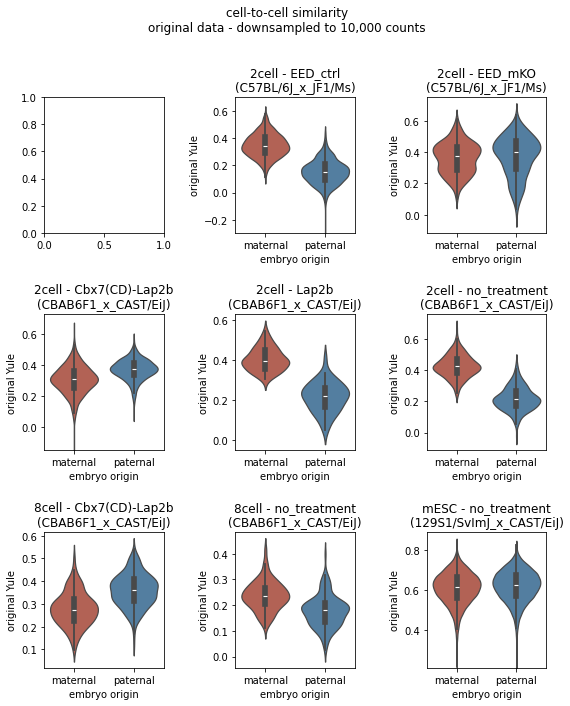

In [56]:
ind = anno.is_heterozygous
anno_select = anno[ind].copy()
plot_downsampled = True
plot_col = 'original'
select_thresh = 10000
metric = 'Yule'

nplot = len(list(anno_select.groupby(['stage','genotype','treatment'])))
ncol = 3
nrow = int(np.ceil(nplot/ncol))
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3,nrow*3.5))
plt.subplots_adjust(wspace=.6, hspace=.6)
counter = 0

stat_ls = defaultdict(list)

for info, _ in anno_select.groupby(['stage','genotype','treatment']):
    
    # collect relevant data
    
    if plot_downsampled:
        assert select_thresh in downsample_threshold_ls
        dataselect_ls = ['down_%s_orig' % select_thresh, 'down_%s_sim' % select_thresh]
    else:
        dataselect_ls = ['full_orig', 'full_sim']

    to_plot = list()
    for ds in dataselect_ls:

        df = pairwise_similarity_scores[info].copy()
        ind = (df['sample1'] != df['sample2']) & (df['metric'] == metric) & (df['dataset'] == ds)
        df = df[ind]
        df['dataset'] = df['dataset'].apply(func = lambda d: 'original' if 'orig' in d else 'simulated')

        to_plot.append(df)

    to_plot = pd.concat(to_plot, axis=0)
    to_plot = to_plot[to_plot['allele'].isin(['maternal','paternal'])]
    
    if len(to_plot) == 0:
        counter += 1
        continue


    to_plot = to_plot.drop(columns=['metric'])
    to_plot = to_plot.set_index(['allele', 'sample1', 'sample2', 'dataset']).unstack()
    to_plot.columns = [c[1] for c in to_plot.columns.values]
    to_plot = to_plot.reset_index()
    to_plot['corrected'] = to_plot['original'] - to_plot['simulated']
    to_plot['sample_pair'] = to_plot.apply(axis=1, func=lambda r: ':'.join(sorted([r['allele'], r['sample1'], r['sample2']])))
    ind = to_plot['sample_pair'].duplicated()
    assert ind.mean() == 0.5
    to_plot = to_plot[~ind]
    
    ax = axes.flatten()[counter]
    counter += 1
    
    sns.violinplot(
        x=to_plot['allele'], y=to_plot[plot_col], hue=to_plot['allele'],
        order=['maternal', 'paternal'], ax=ax,
        dodge=False, palette=color_dict['allele']
        
    )

    
    # format plot
    ax.set_title('%s - %s\n(%s)' % (info[0], info[2], info[1]))
    ax.set_ylabel('%s %s' % (plot_col, metric))
    ax.set_xlabel('embryo origin')
    
    # adjust yrange to exclude outliers
    newlim = define_ylim(to_plot, 'allele', plot_col, ax.get_ylim())
    ax.set_ylim(newlim)
    
    # get stats
    stat_ls['stage'].append(info[0])
    stat_ls['genotype'].append(info[1])
    stat_ls['treatment'].append(info[2])
    all_samples = np.concatenate([to_plot['sample1'].values, to_plot['sample2'].values])
    all_samples = np.unique(all_samples)
    stat_ls['n_samples'].append(len(all_samples))
    stat_ls['condition_1'].append('maternal')
    stat_ls['condition_2'].append('paternal')
    A = to_plot.loc[to_plot['allele']=='maternal',plot_col].values
    B = to_plot.loc[to_plot['allele']=='paternal',plot_col].values
    for i, vals in enumerate([A, B]):
        i += 1
        stat_ls['n_pairs_%d'%i].append(len(vals))
        stat_ls['mean_%d'%i].append(np.mean(vals))
        stat_ls['median_%d'%i].append(np.median(vals))
        stat_ls['std_%d'%i].append(np.std(vals))
    s, p = stats.mannwhitneyu(A, B)
    stat_ls['MannWhitneyU_stat'].append(s)
    stat_ls['MannWhitneyU_pval'].append(p)

if plot_downsampled:
    t = 'cell-to-cell similarity\n{} data - downsampled to {:,} counts'.format(plot_col, select_thresh)
else:
    t = 'cell-to-cell similarity\n{} data - Full data'.format(plot_col)
plt.suptitle(t, y=1)
   
# format stat dataframe
stat_df = pd.DataFrame(stat_ls)
stat_df['metric'] = metric
if plot_downsampled:
    stat_df['downsampled_to'] = select_thresh
stat_df['dataset'] = plot_col
    
# save results
outfmt = 'similarity_scores.maternal_vs_paternal.all_conditions.{dataset}_{metric}.{downsample}.binsize_{binsize:d}.pdf'
if plot_downsampled:
    tmp = 'downsampled_to_%d' % select_thresh
else:
    tmp = 'full_data'
outfn = FIGOUTDIR + outfmt.format(dataset=plot_col, metric=metric, downsample=tmp, binsize=BINSIZE)
plt.savefig(outfn, bbox_inches='tight')
outfn = outfn.replace('pdf', 'stats.tsv')
stat_df.to_csv(outfn, sep='\t', header=True, index=False)

# 7. Similarity scores for different parts of the genome

## 7.1 Load annotation of NL affinity and H3K27me3 level

In [57]:
fn = '../output/figures/10_Preimplantation.integrating_findings.part1.NL_association_based_on_NL_affinity_and_H3K27me3_levels/NL_affinity_and_H3K27me3_categories.tsv.gz'
nl_affinity = pd.read_table(fn, dtype={'chrom':str})
nl_affinity['bin_ind'] = (nl_affinity['start'] // BINSIZE).astype(int)
nl_affinity = nl_affinity.drop(columns=['NL_affinity_cat', 'H3K27me3_maternal_cat', 'H3K27me3_paternal_cat', 'paternal_exclude', 'Kcluster'])


In [58]:
# enlarge binsize
nl_affinity = nl_affinity.groupby(['chrom','bin_ind']).agg({
    'start': np.min, 'end': np.max, 'NL_affinity': np.mean, 'H3K27me3_maternal': np.mean, 'H3K27me3_paternal': np.mean
}).reset_index()

nl_affinity

chrom  bin_ind      start        end  NL_affinity  H3K27me3_maternal  \
0        1        3    3000000    4000000     0.396262           0.419337   
1        1        4    4000000    5000000     0.325234           0.166026   
2        1        5    5000000    6000000     0.363318           0.446683   
3        1        6    6000000    7000000     0.457009           0.092565   
4        1        7    7000000    8000000     0.483178           0.292692   
...    ...      ...        ...        ...          ...                ...   
2367     9      120  120000000  121000000     0.036449           0.195235   
2368     9      121  121000000  122000000     0.035306           0.267439   
2369     9      122  122000000  123000000     0.087850           0.186743   
2370     9      123  123000000  124000000     0.275701           0.082861   
2371     9      124  124000000  124500000     0.422430           0.283325   

      H3K27me3_paternal  
0              0.576933  
1              0.360408  
2              0.413131  
3              0.405762  
4              0.391666  
...                 ...  
2367           0.059275  
2368           0.066007  
2369           0.081364  
2370           0.124772  
2371           0.386788  

[2372 rows x 7 columns]

### Compute categories of NL affinity

In [59]:
NL_THRESH = [0.25, 0.75]

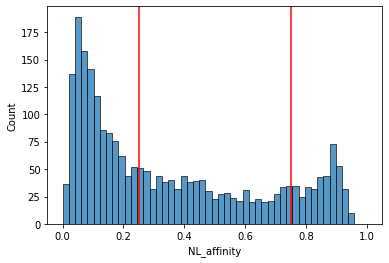

In [60]:
fig, ax = plt.subplots()
sns.histplot(nl_affinity['NL_affinity'], bins=np.linspace(0,1,50), ax=ax)
for t in NL_THRESH:
    ax.axvline(t, c='r')

In [61]:
nl_affinity['NL_affinity_cat'] = 'NL:low'
nl_affinity.loc[nl_affinity.NL_affinity >= NL_THRESH[0], 'NL_affinity_cat'] = 'NL:mid'
nl_affinity.loc[nl_affinity.NL_affinity >= NL_THRESH[1], 'NL_affinity_cat'] = 'NL:high'

nl_affinity['NL_affinity_cat'] = pd.Categorical(nl_affinity['NL_affinity_cat'], categories=['NL:low', 'NL:mid', 'NL:high'])


### Compute categories of H3K27me3 level

In [62]:
K27_THRESH = [0.2, 0.8]

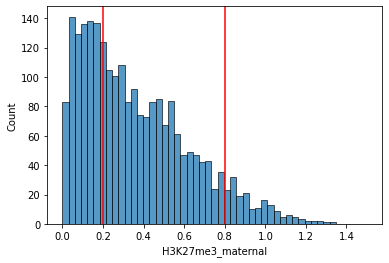

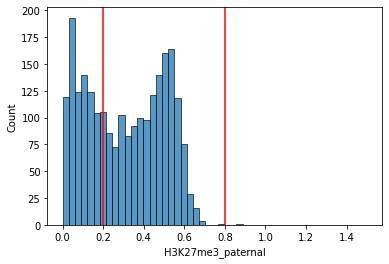

In [63]:
fig, ax = plt.subplots()
sns.histplot(nl_affinity['H3K27me3_maternal'], bins=np.linspace(0,1.5,50), ax=ax)
for t in K27_THRESH:
    ax.axvline(t, c='r')
    
fig, ax = plt.subplots()
sns.histplot(nl_affinity['H3K27me3_paternal'], bins=np.linspace(0,1.5,50), ax=ax)
for t in K27_THRESH:
    ax.axvline(t, c='r')

In [64]:
for allele in ['maternal', 'paternal']:
    col = 'H3K27me3_%s' % allele
    col_cat = 'H3K27me3_%s_cat' % allele
    nl_affinity[col_cat] = 'K27:low'
    nl_affinity.loc[nl_affinity[col] >= K27_THRESH[0], col_cat] = 'K27:mid'
    nl_affinity.loc[nl_affinity[col] >= K27_THRESH[1], col_cat] = 'K27:high'
    
    nl_affinity[col_cat] = pd.Categorical(nl_affinity[col_cat], categories=['K27:low', 'K27:mid', 'K27:high'])


## See numbers

In [65]:
nl_affinity.groupby(['NL_affinity_cat', 'H3K27me3_maternal_cat']).size().unstack()

H3K27me3_maternal_cat  K27:low  K27:mid  K27:high
NL_affinity_cat                                  
NL:low                     501      606        82
NL:mid                     269      470        55
NL:high                     63      286        40

In [66]:
nl_affinity.groupby(['NL_affinity_cat', 'H3K27me3_paternal_cat']).size().unstack()

H3K27me3_paternal_cat  K27:low  K27:mid  K27:high
NL_affinity_cat                                  
NL:low                     829      360         0
NL:mid                      35      759         0
NL:high                      0      388         1

## 2.1 Compute similarities

In [67]:
select_chroms = np.arange(1,20).astype(str)
pairwise_similarity_scores_per_region = dict()
m_ind = np.concatenate([mapab[c] for c in select_chroms]) > MINMAP


dataset_dict = {
    'full_orig': damid_binary,
    'full_sim': damid_binary_sim
}
dataset_counts_dict = {
    'full_orig': damid_counts,
    'full_sim': damid_counts_sim
}

for downtarget in damid_binary_down:
    dataset_dict['down_%d_orig' % downtarget] = damid_binary_down[downtarget]
    dataset_dict['down_%d_sim' % downtarget] = damid_binary_down_sim[downtarget]
    dataset_counts_dict['down_%d_orig' % downtarget] = damid_counts_down[downtarget]
    dataset_counts_dict['down_%d_sim' % downtarget] = damid_counts_down_sim[downtarget]

ind = (anno.cellcount == 1) & anno.is_heterozygous
for info, anno_df in anno[ind].groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']):

    info = (info[0], info[1], info[2])
    print(info)
    result_ls = list()
    
    for parent in ['maternal', 'paternal']:
        samples = anno_df[anno_df.DamID_PASS_allelic].index.values

        groupcols = ['NL_affinity_cat', 'H3K27me3_%s_cat' % parent]
        for (nl_cat, k27_cat), region_df in nl_affinity.groupby(groupcols):
            
            if len(region_df) < 20:
                print('Excluding category due to limited number of bins: ', nl_cat, k27_cat)
                continue
            bin_select = {c: df['bin_ind'].values for c, df in region_df.groupby('chrom')}
            chroms_present = region_df['chrom'].unique()

            for ds in dataset_dict:

                tmp = np.array(list(dataset_dict[ds][parent].keys()))
                select_ind = np.isin(samples, tmp)
                select_samples = samples[select_ind]

                ## select binary data
                D = list()
                for s in select_samples: # somatic chromosomes only
                    y = np.concatenate([dataset_dict[ds][parent][s][c][bin_select[c]] for c in chroms_present])
                    D.append(y)
                D = np.array(D)

                if D.shape[0] < 2:
                    continue

#                 print(info, parent, ds, len(select_samples))

                ## jaccard on binary data
                C = 1 - pairwise_distances(D.astype(bool), metric='jaccard')
                df = pd.DataFrame(C, columns=select_samples, index=select_samples).reset_index().rename(columns={'index': 'sample1'})
                df = df.melt(id_vars='sample1', var_name='sample2', value_name='similarity')
                df['metric'] = 'Jaccard'
                df['dataset'] = ds
                df['allele'] = parent
                df['NL_affinity_cat'] = nl_cat
                df['H3K27me3_cat'] = k27_cat
                df['n_bins'] = D.shape[1]
                result_ls.append(df)

                ## yule on binary data
                C = 1 - pairwise_distances(D.astype(bool), metric='yule')
                df = pd.DataFrame(C, columns=select_samples, index=select_samples).reset_index().rename(columns={'index': 'sample1'})
                df = df.melt(id_vars='sample1', var_name='sample2', value_name='similarity')
                df['metric'] = 'Yule'
                df['dataset'] = ds
                df['allele'] = parent
                df['NL_affinity_cat'] = nl_cat
                df['H3K27me3_cat'] = k27_cat
                df['n_bins'] = D.shape[1]
                result_ls.append(df)
                
                ## select lognorm data
                D = list()
                for s in select_samples:
                    m = np.concatenate([mapab_rpkm[info[1]][parent][c][bin_select[c]] for c in chroms_present])

                    if parent == 'combined':
                        y = np.concatenate([dataset_counts_dict[ds][parent][s][c][bin_select[c]] for c in chroms_present])
                        d = sum([dataset_counts_dict[ds][parent][s][c].sum() for c in chroms_present])
                    else:
                        ym = np.concatenate([dataset_counts_dict[ds]['maternal'][s][c][bin_select[c]] for c in chroms_present])
                        dm = sum([dataset_counts_dict[ds]['maternal'][s][c].sum() for c in chroms_present])
                        yp = np.concatenate([dataset_counts_dict[ds]['paternal'][s][c][bin_select[c]] for c in chroms_present])
                        dp = sum([dataset_counts_dict[ds]['paternal'][s][c].sum() for c in chroms_present])
                        y = ym if parent == 'maternal' else yp
                        d = dm + dp
                    y = y / d / BINSIZE * 1e9
                    D.append(np.log2( (y + 1) / (m + 1) ))

                ## Spearman on logOE
                D = np.array(D).T
                D = pd.DataFrame(D, columns=select_samples)
                C = D.corr(method='spearman')
    #             C = 1 - pairwise_distances(D.astype(bool), metric='yule')
                df = pd.DataFrame(C, columns=select_samples, index=select_samples).reset_index().rename(columns={'index': 'sample1'})
                df = df.melt(id_vars='sample1', var_name='sample2', value_name='similarity')
                df['metric'] = 'Spearman'
                df['dataset'] = ds
                df['allele'] = parent
                df['NL_affinity_cat'] = nl_cat
                df['H3K27me3_cat'] = k27_cat
                df['n_bins'] = D.shape[0]
                result_ls.append(df)
            
    if len(result_ls) == 1:
        result_df = result_ls[0]
    elif len(result_ls) == 0:
        continue
    else:
        result_df = pd.concat(result_ls, axis=0)
    pairwise_similarity_scores_per_region[info] = result_df

('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')
Excluding category due to limited number of bins:  NL:high K27:high
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')
Excluding category due to limited number of bins:  NL:high K27:high
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
Excluding category due to limited number of bins:  NL:high K27:high
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')
Excluding category due to limited number of bins:  NL:high K27:high
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b')
Excluding category due to limited number of bins:  NL:high K27:high
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')
Excluding category due to limited number of bins:  NL:high K27:high
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')
Excluding category due to limited number of bins:  NL:high K27:high
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')
Excluding category due to limited number of bins:  NL:high K27:high
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment')
Excluding category due to limited 

In [68]:
def plot_nice_similarity_scores_per_region(anno_select, metric, allele, plot_downsampled, select_thresh, plot_col, color_by=''):
    
    assert plot_col in ['original', 'simulated', 'corrected']
    if len(color_by):
        assert color_by in ['stage', 'treatment']
    
    # determine number and order of conditions
    anno_select['label'] = anno_select.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))
    anno_select['stage'] = pd.Categorical(anno_select['stage'], categories=stage_order)
    anno_select['treatment'] = pd.Categorical(anno_select['treatment'], categories=treatment_order)
    n_conditions = len(list(anno_select.groupby(['stage', 'genotype', 'treatment'])))
    label_order = anno_select.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

    # collect relevant data
    to_plot = list()
    if plot_downsampled:
        assert select_thresh in downsample_threshold_ls
        dataselect_ls = ['down_%s_orig' % select_thresh, 'down_%s_sim' % select_thresh]
    else:
        dataselect_ls = ['full_orig', 'full_sim']

    for ds in dataselect_ls:

        for info, _ in anno_select.groupby(['stage', 'genotype', 'treatment']):

            df = pairwise_similarity_scores_per_region[info].copy()
            ind = (df['sample1'] != df['sample2']) & (df['allele'] == allele) & (df['metric'] == metric) & (df['dataset'] == ds)
            df = df[ind]
            for col in ['stage', 'genotype', 'treatment', 'label']:
                df[col] = anno_select.loc[df.sample1.values,col].values
            df['dataset'] = df['dataset'].apply(func = lambda d: 'original' if 'orig' in d else 'simulated')

            to_plot.append(df)

    to_plot = pd.concat(to_plot, axis=0)
#     print(to_plot.head())
    
    
    to_plot = to_plot.drop(columns=['metric', 'allele'])
    to_plot = to_plot.set_index(
        ['label', 'stage', 'genotype', 'treatment', 
         'sample1', 'sample2', 'n_bins', 'NL_affinity_cat', 'H3K27me3_cat', 'dataset'
        ]).unstack()
    to_plot.columns = [c[1] for c in to_plot.columns.values]
    to_plot = to_plot.reset_index()
    to_plot['corrected'] = to_plot['original'] - to_plot['simulated']
    to_plot['sample_pair'] = to_plot.apply(axis=1, func=lambda r: ':'.join(sorted([r['sample1'], r['sample2']])))
    ind = to_plot[['sample_pair', 'NL_affinity_cat', 'H3K27me3_cat']].duplicated()
    assert ind.mean() == 0.5, ind.mean()
    to_plot = to_plot[~ind]
    
    # set up plot
    fig, axes = plt.subplots(3,3,figsize=(9,9), sharex=True)

    for irow, nl_cat in enumerate(['NL:high', 'NL:mid', 'NL:low']):
        for icol, k27_cat in enumerate(['K27:low', 'K27:mid', 'K27:high']):
            
            to_plot_cat = to_plot[(to_plot.NL_affinity_cat==nl_cat) & (to_plot.H3K27me3_cat == k27_cat)].copy()
            ax = axes[irow, icol]
            if len(to_plot_cat) < 2:
                continue
            
            ## plot original
            if len(color_by) > 0:
                sns.violinplot(
                    x=to_plot_cat['label'], y=to_plot_cat[plot_col], hue=to_plot_cat[color_by], 
                    order=label_order, ax=ax, dodge=False, palette=color_dict[color_by]
                )
                
            else:
                sns.violinplot(x=to_plot_cat['label'], y=to_plot_cat[plot_col], order=label_order, ax=ax)

            # format plot
            if icol == 0:
                ax.set_ylabel('%s\n%s %s' % (nl_cat, plot_col, metric), fontsize=14)
            else:
                ax.set_ylabel('')
            if irow == 2:
                ax.set_xticks(ax.get_xticks())
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
                ax.set_xlabel(k27_cat, fontsize=14)
            else:
                ax.set_xlabel('')

            if plot_downsampled:
                t = 'cell-to-cell similarity - {} allele\n{} data - downsampled to {:,} counts'.format(allele, plot_col, select_thresh)
            else:
                t = 'cell-to-cell similarity - {} allele\n{} data - Full data'.format(allele, plot_col)
            if (irow == 0) and (icol == 1):
                ax.set_title(t)
            if (irow == 2) and (icol == 2) and (len(color_by) > 0):
                ax.legend(loc=(1,0), title=color_by)
            else:
                ax.legend_.remove()
                
            assert len(to_plot_cat['n_bins'].unique()) == 1, to_plot_cat.groupby('n_bins').size()
            ax.text(0.99, 0.99, '# bins = %d' % to_plot_cat['n_bins'].values[0], transform=ax.transAxes, ha='right', va='top')

            # adjust yrange to exclude outliers
#             newlim = define_ylim(to_plot, 'label', plot_col, ax.get_ylim())
#             ax.set_ylim(newlim)

        #     # collect stastical information
        #     stat_df = statistical_results_between_conditions(to_plot, plot_col)
        #     stat_df['allele'] = allele
        #     stat_df['metric'] = metric
        #     if plot_downsampled:
        #         stat_df['downsampled_to'] = select_thresh
        #     stat_df['dataset'] = plot_col

        #     return stat_df

    return

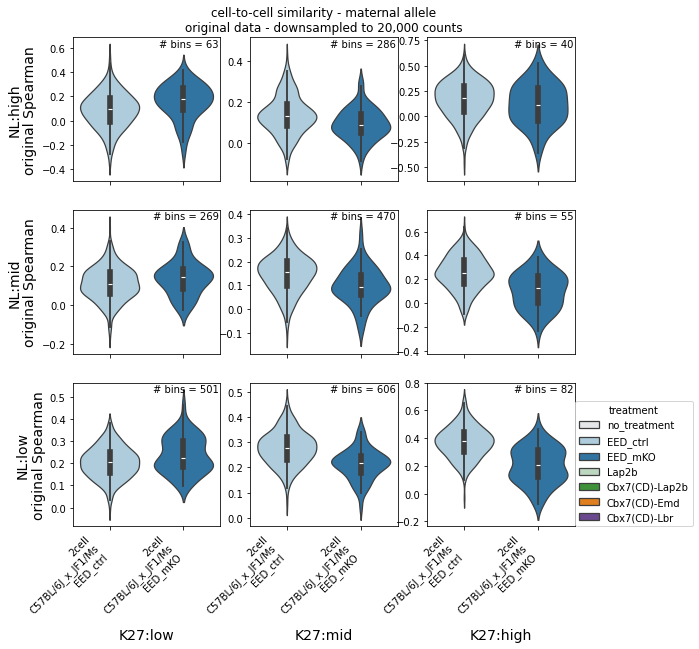

In [69]:
anno_select = anno[anno.treatment.str.contains('EED')].copy()
metric = 'Spearman'
allele = 'maternal'
plot_downsampled = True
select_thresh = 20000
color_by = 'treatment'

stat_df = plot_nice_similarity_scores_per_region(
    anno_select, metric, allele, plot_downsampled, select_thresh, 'original', color_by
)

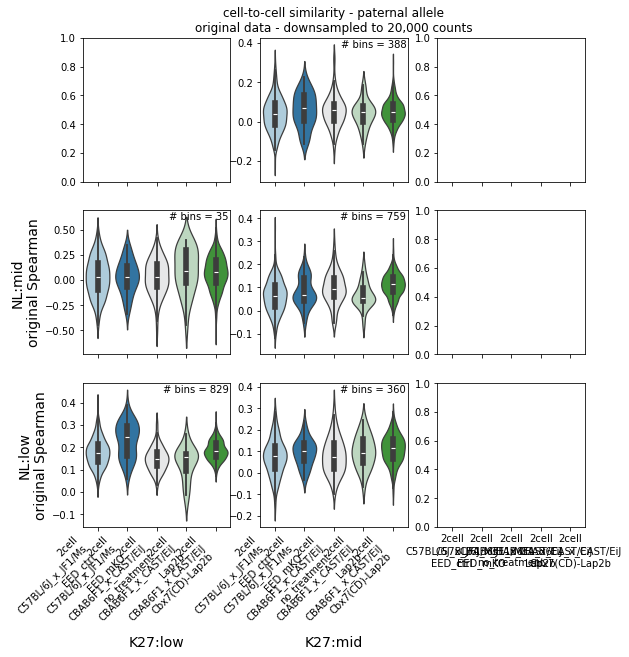

In [70]:
ind = (anno.stage=='2cell') & (anno.is_heterozygous)
anno_select = anno[ind].copy()
metric = 'Spearman'
allele = 'paternal'
plot_downsampled = True
select_thresh = 20000
color_by = 'treatment'

stat_df = plot_nice_similarity_scores_per_region(
    anno_select, metric, allele, plot_downsampled, select_thresh, 'original', color_by
)

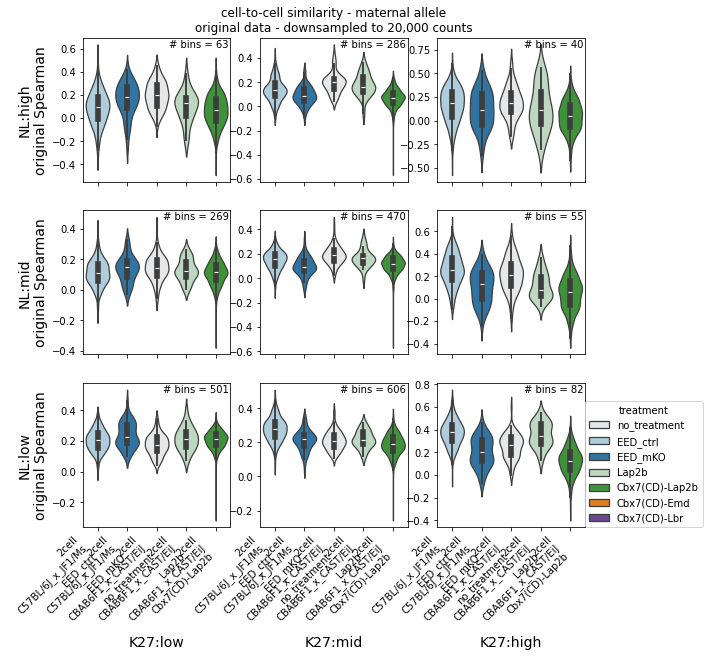

In [71]:
ind = (anno.stage=='2cell') & (anno.is_heterozygous)
anno_select = anno[ind].copy()
metric = 'Spearman'
allele = 'maternal'
plot_downsampled = True
select_thresh = 20000
color_by = 'treatment'

stat_df = plot_nice_similarity_scores_per_region(
    anno_select, metric, allele, plot_downsampled, select_thresh, 'original', color_by
)